#### Editing log:
##### Orignal from 09/18/2022
##### Edited in 02/15/2023: adding mutation features
##### Edited in 02/21/2023: finish analysis

In [5]:
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
#from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score


In [57]:
# Define functions

def Filter_low_Expr(arr):
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg):
    array_list = []
    new_id_list = []
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            #cur_regulators_ids.append(dic_gene_map[i])

            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size):
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features): #modified at 11:46 AM Feb 15
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {'max_depth': [2,3,4],
                                   'n_estimators': [100], 
                                   'learning_rate': [0.05, 0.1],
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], max_depth=para['max_depth'], n_estimators=para['n_estimators'])
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions = clf.predict(test_data)
    
    predictions_independent = clf.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))

    # Evaluate the accuracy of the XGBoost model
    accuracy = accuracy_score(test_labels, predictions)
    accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    #print("# Accuracy:  the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true")
    #print("Accuracy: ", accuracy)

    cm = confusion_matrix(  list(test_labels), predictions)
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1])
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    #print("Recall: " + str(recall))
    #print("# Recall: TP / (TP + FN)")

    print("confusion_matrix")
    print(cm)

    #print("sensitivity: "+ str(sensitivity))

    #print("Precision: " + str(precision))
    #print("# Precision = TP / (TP + FP) ")
    f1 = f1_score(list(test_labels), predictions)
    f1_independent = f1_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    result_summary['validation_set'] = len(test_labels)
    result_summary['test_set'] = len(independent_labels)

    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy
    result_summary['ACC_independent'] = accuracy_independent

    result_summary['Precision'] = precision
    result_summary['sensitivity'] = sensitivity
    result_summary['F1_score'] = f1
    result_summary['F1_score_independent'] = f1_independent
    result_summary['features'] = result_feature
    return(result_summary)

def select_duplicated_col(my_list):
    duplicates = []
    for item in my_list:
        if my_list.count(item) > 1:
            if item not in duplicates:
                duplicates.append(item)
    return(duplicates)



In [8]:
# Load data
# Gene expression from BeatAML wave 1 and 2
Drug_data = pd.read_csv("../../Data_resource/Drug_Response.csv",index_col = "Unnamed: 0") 


GE = pd.read_csv("../../Data_resource/RPKM.csv",index_col = "Unnamed: 0")
data_all  = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_Pam/notebooks/beatAML_wave1_2_feature_ic50_highExpr.csv", index_col= "Unnamed: 0")
mut_w1_2 = data_all.iloc[:,0:22].dropna()

#Load features from features that predict drug response, regulatory graph and house keeping genes
sele_house_keeping =  ["GPS2", "RPS10","ZNF91","FNTA","PSMC1","GPS1","MLH1","ARAF","SF3B2","PSMD2","SRP14","GNB1","HNRNPK","ARF1","RPS11"]
KG_expr_resp = pd.read_csv("../KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_reg = pd.read_csv("../KG_regulatory_graph.csv")


# Load testing data from BeatAML wave 1-4
BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")
BeatAML_mut_matrix_sele_w3_4 = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/BeatAML_mut_matrix_sele_w3_4.csv", index_col = "Unnamed: 0")

In [15]:
print("Number of drugs in BeatAML wave 1/2:" + str(len(set(Drug_data['inhibitor']))))
print("Number of samples with drug screening data in BeatAML wave 1/2:" + str(len(set(Drug_data['lab_id']))))
print(data_all.shape)
print(mut_w1_2.shape)

Number of drugs in BeatAML wave 1/2:122
Number of samples with drug screening data in BeatAML wave 1/2:528
(783, 17863)
(608, 22)


In [482]:
KG_expr_resp.loc[KG_expr_resp['Drug'] == "Venetoclax"]

Unnamed: 0        Drug                  Gene                Symbol  \
1383        1383  Venetoclax       ENSG00000074054                CLASP1   
1384        1384  Venetoclax       ENSG00000108840                 HDAC5   
1385        1385  Venetoclax       ENSG00000115295                 CLIP4   
1386        1386  Venetoclax       ENSG00000119655                  NPC2   
1387        1387  Venetoclax       ENSG00000123130                 ACOT9   
1388        1388  Venetoclax       ENSG00000130725                 UBE2M   
1389        1389  Venetoclax       ENSG00000131042                LILRB2   
1390        1390  Venetoclax       ENSG00000133884                  DPF2   
1391        1391  Venetoclax       ENSG00000134463                ECHDC3   
1392        1392  Venetoclax       ENSG00000135414                 GDF11   
1393        1393  Venetoclax       ENSG00000137474                 MYO7A   
1394        1394  Venetoclax       ENSG00000139132                  FGD4   
1395        1395  Venetoclax       ENSG00000145730                   PAM   
1396        1396  Venetoclax       ENSG00000151650                 VENTX   
1397        1397  Venetoclax       ENSG00000153531               ADPRHL1   
1398        1398  Venetoclax       ENSG00000163611                SPICE1   
1399        1399  Venetoclax       ENSG00000164190                 NIPBL   
1400        1400  Venetoclax       ENSG00000164828                  SUN1   
1401        1401  Venetoclax       ENSG00000169733                  RFNG   
1402        1402  Venetoclax       ENSG00000170458                  CD14   
1403        1403  Venetoclax       ENSG00000170866                LILRA3   
1404        1404  Venetoclax       ENSG00000170873                 MTSS1   
1405        1405  Venetoclax       ENSG00000171791                  BCL2   
1406        1406  Venetoclax       ENSG00000173372                  C1QA   
1407        1407  Venetoclax       ENSG00000179938               GOLGA8J   
1408        1408  Venetoclax       ENSG00000181798             LINC00471   
1409        1409  Venetoclax       ENSG00000184381                PLA2G6   
1410        1410  Venetoclax       ENSG00000196653                ZNF502   
1411        1411  Venetoclax       ENSG00000197081                 IGF2R   
1412        1412  Venetoclax       ENSG00000197363                ZNF517   
1413        1413  Venetoclax       ENSG00000204682                CASC10   
1414        1414  Venetoclax       ENSG00000215022           RP1-257A7.4   
1415        1415  Venetoclax       ENSG00000223977            AC138623.1   
1416        1416  Venetoclax       ENSG00000233229               CNOT7P1   
1417        1417  Venetoclax       ENSG00000236662          RP11-108L7.4   
1418        1418  Venetoclax       ENSG00000237451             CDK2AP2P2   
1419        1419  Venetoclax       ENSG00000241360                  PDXP   
1420        1420  Venetoclax       ENSG00000250346               EEF1GP2   
1421        1421  Venetoclax       ENSG00000259940          CTD-3203P2.1   
1422        1422  Venetoclax       ENSG00000260193           RP11-83N9.5   
1423        1423  Venetoclax       ENSG00000268364              SMC5-AS1   
1424        1424  Venetoclax       ENSG00000269293           ZSCAN16-AS1   
1425        1425  Venetoclax       ENSG00000270820         RP11-355B11.2   
1426        1426  Venetoclax       ENSG00000272168                CASC15   
1427        1427  Venetoclax        Venetoclax_RSS        Venetoclax_RSS   
1428        1428  Venetoclax  Venetoclax_intercept  Venetoclax_intercept   

           coef Method  Dataset  
1383  -0.042574  Lasso  BeatAML  
1384  -0.042743  Lasso  BeatAML  
1385   0.001350  Lasso  BeatAML  
1386   0.027242  Lasso  BeatAML  
1387   0.012263  Lasso  BeatAML  
1388  -0.002936  Lasso  BeatAML  
1389   0.021700  Lasso  BeatAML  
1390  -0.007372  Lasso  BeatAML  
1391   0.023619  Lasso  BeatAML  
1392  -0.049505  Lasso  BeatAML  
1393   0.015225  Lasso  BeatAML  
1394   0.070839  Lasso  B

In [470]:
#KG_expr_resp_yue = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/Manuscript/Supplemental_Tables/beatAML_drug_prediction_coefs_lasso_Yue.csv")
#KG_expr_resp_yue.index = KG_expr_resp_yue['drug']
#KG_expr_resp_yue = KG_expr_resp_yue.iloc[:,2:]
#KG_expr_resp_yue = KG_expr_resp_yue.transpose()
#test = KG_expr_resp_yue['Venetoclax']
#test_df = pd.DataFrame({"gene":test.index, "coef":test.values})
#test_df.loc[test_df['coef'] != 0]
#test[test != 0]

In [16]:
KG_reg.loc[KG_reg['Target_symbol'] == 'BCL2']

Unnamed: 0      Target_gene                   Regulator          Coef  \
176000      176000  ENSG00000171791                      BCL11A  3.152486e-02   
176001      176001  ENSG00000171791                        EGR1  2.786670e-02   
176002      176002  ENSG00000171791                       FOXO1 -3.993203e-02   
176003      176003  ENSG00000171791                       KLF12  1.942433e-02   
176004      176004  ENSG00000171791                       MYBL1  1.791337e-02   
176005      176005  ENSG00000171791                         MYC  7.385902e-04   
176006      176006  ENSG00000171791                      NFATC2  1.344332e-01   
176007      176007  ENSG00000171791                       NFKB2 -4.357412e-02   
176008      176008  ENSG00000171791                       NR3C2  8.941549e-02   
176009      176009  ENSG00000171791                       SATB1  1.957812e-01   
176010      176010  ENSG00000171791                         SP1 -6.550449e-02   
176011      176011  ENSG00000171791                         SP4  7.642947e-03   
176012      176012  ENSG00000171791                        TCF4 -2.339283e-02   
176013      176013  ENSG00000171791                       TSHZ1  8.941063e-02   
176014      176014  ENSG00000171791                       ZNF22  2.426004e-01   
176015      176015  ENSG00000171791                      MIR628 -2.831321e-02   
176016      176016  ENSG00000171791                    MIR600HG  1.288874e-02   
176017      176017  ENSG00000171791                     MIR3648 -6.195934e-03   
176018      176018  ENSG00000171791                     MIR17HG  1.251156e-02   
176019      176019  ENSG00000171791                    MIR548AR -2.224600e-02   
176020      176020  ENSG00000171791                     MIR5690 -7.662272e-02   
176021      176021  ENSG00000171791                     MIR3687 -5.499920e-03   
176022      176022  ENSG00000171791                      MIR29A -2.318829e-02   
176023      176023  ENSG00000171791         ENSG00000171791_RSS  1.869930e+02   
176024      176024  ENSG00000171791  ENSG00000171791_intercept_ -4.973764e-16   

       Target_symbol  
176000          BCL2  
176001          BCL2  
176002          BCL2  
176003          BCL2  
176004          BCL2  
176005          BCL2  
176006          BCL2  
176007          BCL2  
176008          BCL2  
176009          BCL2  
176010          BCL2  
176011          BCL2  
176012          BCL2  
176013          BCL2  
176014          BCL2  
176015          BCL2  
176016          BCL2  
176017          BCL2  
176018          BCL2  
176019          BCL2  
176020          BCL2  
176021          BCL2  
176022          BCL2  
176023          BCL2  
176024          BCL2

In [17]:
KG_expr_resp.shape[0]/len(set(KG_expr_resp['Drug']))

55.74590163934426

In [18]:
len(set(Drug_data['inhibitor']))

122

In [22]:
#Formating gene expression data for training data
GE.index = GE['Gene']
gene_list_w12 = (list(GE.index))
sample_list_w12 = list(set(GE.columns) - set(['Gene','Symbol']))
input_data = GE.loc[list(gene_list_w12), sample_list_w12]


#Formating gene expression data for testing data
BeatAML_wave_3_expr.index = BeatAML_wave_3_expr['stable_id']
gene_list = (list(BeatAML_wave_3_expr.index))
sample_list = list(set(BeatAML_wave_3_expr.columns) - set(['stable_id','display_label','description','biotype']) - set(sample_list_w12))
input_data_test = BeatAML_wave_3_expr.loc[list(gene_list), sample_list]

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]


In [24]:
input_data.shape

(22843, 451)

In [23]:
input_data_test.shape

(23150, 256)

In [25]:
def features(Drug):
    res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
    res1 = res1.sort_values(by = ['coef'])
    predictors = list(res1['Gene'])
    predictors.remove(Drug+"_RSS")
    predictors.remove(Drug+"_intercept")

    # Selection of the second neighbors
    #res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors[0:5] +  predictors[len(predictors)-5:len(predictors)])]
    res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
    res2 = res2.loc[res2['Coef'] <0]

    selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
    selected_genes.remove(Drug+"_RSS")
    selected_genes.remove(Drug+"_intercept")
    print(len(selected_genes))

    # Formating house keeping gene ids
    sele_house_keeping_id = []
    selected_genes_id = []

    for g in selected_genes:
        selected_genes_id.append(dic_gene_map[g])

    for g in sele_house_keeping:
        if g in dic_gene_map:
            sele_house_keeping_id.append(dic_gene_map[g])

    # Formatting features
    new_feature_df_t = formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg)
    new_feature_df_test = formating_relative_expression(input_data_test,selected_genes_id, sele_house_keeping_id, KG_reg)

    new_feature_df_test_comb = pd.concat([BeatAML_mut_matrix_sele_w3_4, new_feature_df_test], axis = 1)
    new_feature_df_t_comb = pd.concat([mut_w1_2,new_feature_df_t],axis = 1)

    new_feature_df_test = new_feature_df_test_comb.dropna()
    new_feature_df_t = new_feature_df_t_comb.dropna()

    return(new_feature_df_t,new_feature_df_test)

In [110]:
# Feature selection: Selection of first neighbors
Drug = "JQ1"
#Drug = "Trametinib (GSK1120212)"
#Drug = "Selumetinib (AZD6244)"
#Drug = "Venetoclax"
res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
res1 = res1.sort_values(by = ['coef'])
predictors = list(res1['Gene'])
predictors.remove(Drug+"_RSS")
predictors.remove(Drug+"_intercept")

# Selection of the second neighbors
#res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors[0:5] +  predictors[len(predictors)-5:len(predictors)])]
res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
res2 = res2.loc[res2['Coef'] <0]

selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
selected_genes.remove(Drug+"_RSS")
selected_genes.remove(Drug+"_intercept")
print(len(selected_genes))

# Formating house keeping gene ids
sele_house_keeping_id = []
selected_genes_id = []

for g in selected_genes:
    selected_genes_id.append(dic_gene_map[g])
    
for g in sele_house_keeping:
    if g in dic_gene_map:
        sele_house_keeping_id.append(dic_gene_map[g])

# Formatting features
new_feature_df_t = formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg)
new_feature_df_test = formating_relative_expression(input_data_test,selected_genes_id, sele_house_keeping_id, KG_reg)

new_feature_df_test_comb = pd.concat([BeatAML_mut_matrix_sele_w3_4, new_feature_df_test], axis = 1)
new_feature_df_t_comb = pd.concat([mut_w1_2,new_feature_df_t],axis = 1)

new_feature_df_test = new_feature_df_test_comb.dropna()
new_feature_df_t = new_feature_df_t_comb.dropna()


In [42]:
Drugs = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/Manuscript/Supplemental_Tables/Supplemental_1_Number_of_effective_cases.csv")

In [43]:
Drugs = list(Drugs['Drug'])
print(Drugs)
print(len(Drugs))



['Elesclomol', 'Trametinib (GSK1120212)', 'Ponatinib (AP24534)', 'INK-128', 'Dasatinib', 'Panobinostat', 'JNJ-28312141', 'Rapamycin', 'Foretinib (XL880)', 'Quizartinib (AC220)', 'Venetoclax', 'Sunitinib', 'Dovitinib (CHIR-258)', 'Doramapimod (BIRB 796)', 'PI-103', 'SNS-032 (BMS-387032)', 'Selumetinib (AZD6244)', 'Flavopiridol', 'BEZ235', 'PP242', 'Gilteritinib (ASP-2215)', 'KI20227', 'JAK Inhibitor I', 'Tivozanib (AV-951)', 'Bortezomib (Velcade)', 'Lestaurtinib (CEP-701)', 'Midostaurin', 'Idelalisib', 'Cabozantinib', 'MK-2206', 'Sorafenib', 'Selinexor', '17-AAG (Tanespimycin)', 'Crenolanib', 'GDC-0941', 'KW-2449', 'RAF265 (CHIR-265)', 'MGCD-265', 'JQ1', 'Pelitinib (EKB-569)', 'CHIR-99021', 'Masitinib (AB-1010)', 'NF-kB Activation Inhibitor', 'CI-1040 (PD184352)', 'GSK690693', 'Neratinib (HKI-272)', 'NVP-TAE684', 'CYT387', 'S31-201', 'Ibrutinib (PCI-32765)', 'VX-745', 'A-674563', 'ABT-737', 'Axitinib (AG-013736)', 'Vandetanib (ZD6474)', 'Bosutinib (SKI-606)', 'Vargetef', 'Pazopanib (GW7

In [63]:
#Drug = "Venetoclax"
result_with_threshod = {}
#'CI-1040 (PD184352)',
#for Drug in [ 'GSK690693', 'Neratinib (HKI-272)', 'NVP-TAE684', 'CYT387', 'S31-201', 'Ibrutinib (PCI-32765)', 'VX-745', 'A-674563', 'ABT-737', 'Axitinib (AG-013736)', 'Vandetanib (ZD6474)', 'Bosutinib (SKI-606)', 'Vargetef', 'Pazopanib (GW786034)', 'GSK-1838705A', 'MLN120B', 'Barasertib (AZD1152-HQPA)', 'Linifanib (ABT-869)', 'PRT062607', 'Vatalanib (PTK787)', 'Motesanib (AMG-706)', 'Cediranib (AZD2171)', 'AZD1480', 'AT7519', 'Tofacitinib (CP-690550)',
#for Drug in [ 'SB-431542', 'PD173955', 'XAV-939', 'GSK-1904529A', 'Crizotinib (PF-2341066)', 'DBZ', 'Imatinib', 'Bay 11-7085', 'Vismodegib (GDC-0449)', 'Vemurafenib (PLX-4032)', 'Entospletinib (GS-9973)', 'KU-55933', 'Lenalidomide', 'Tandutinib (MLN518)', 'Roscovitine (CYC-202)', 'Volasertib (BI-6727)', 'PHT-427', 'Tozasertib (VX-680)', 'YM-155', 'Canertinib (CI-1033)', 'PHA-665752', 'GDC-0879', 'Lapatinib', 'Lovastatin', 'Afatinib (BIBW-2992)', 'TG101348', 'Lenvatinib', 'NVP-ADW742']:
for Drug in Drugs:
    print(Drug)
    
    new_feature_df_t,new_feature_df_test = features(Drug)
    result_with_threshod[Drug] = {}
    # Formatting trainning data
    Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
    Drug_sele_df.index = Drug_sele_df['lab_id']
    Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

    df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
    df_sele = df_sele.dropna()
    df_sele.head(3)
    df_sele.shape

    # Formatting testing data using beatAML wave 3/4
    Drug_sele_df_wave3 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]
    Drug_sele_df_wave3.index = Drug_sele_df_wave3['lab_id']
    Drug_sele_df_wave3 =Drug_sele_df_wave3.loc[:,['ic50']]

    df_sele__wave3 = pd.concat([new_feature_df_test, Drug_sele_df_wave3],axis = 1)
    df_sele__wave3 = df_sele__wave3.dropna()
    #df_sele__wave3.head(3)
    #df_sele__wave3.shape


    for Threshod in [0.2, 0.5, 1]:
        data_cur = df_sele # Step 1
        data_cur = data_cur.dropna()
        new_label = []
        for i in data_cur['ic50'].values:
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        data_cur[Drug+"_bi"] = new_label

        df_sele__wave3_cur = df_sele__wave3
        new_label = []
        for i in df_sele__wave3_cur['ic50'].values:
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        df_sele__wave3_cur[Drug+"_bi"] = new_label

        result_all = {}
        result_all_test_w3 = {}
        for random_ in range(0,200,10): 
            sensitive_data = data_cur.loc[data_cur[Drug+"_bi"] == 1]
            resistant_data = data_cur.loc[data_cur[Drug+"_bi"] == 0]
            
            if (sensitive_data.shape[0] > 0 and resistant_data.shape[0] > 0):
                

                train_data_sen, test_data_sen, train_labels_sen, test_labels_sen = train_test_split(sensitive_data.iloc[:,:-2], 
                                                                                    sensitive_data.iloc[:,-1],
                                                                                    test_size = 0.2, random_state = random_)
                train_data_res, test_data_res, train_labels_res, test_labels_res = train_test_split(resistant_data.iloc[:,:-2], 
                                                                                    resistant_data.iloc[:,-1],
                                                                                    test_size = 0.2, random_state = random_)

                train_data = pd.concat([train_data_sen, train_data_res])
                test_data = pd.concat([test_data_sen, test_data_res])
                train_labels = pd.concat([train_labels_sen, train_labels_res])
                test_labels = pd.concat([test_labels_sen, test_labels_res])
                print(test_data.shape)
                test_w3_labels = df_sele__wave3_cur[Drug+"_bi"]
                test_w3_features = df_sele__wave3_cur.iloc[:,:-2]
                print(test_w3_features.shape)
                
                duplicated_list_training = select_duplicated_col(list(train_data.columns))
                unique_list_training = list(set(list(train_data.columns)) - set(duplicated_list_training))
                
                #duplicated_list_testw3 = select_duplicated_col(list(test_w3_features.columns))

                if len(duplicated_list_training) > 0:
                    
                    for col in duplicated_list_training:
                        train_data = train_data.loc[:, ~train_data.columns.duplicated()]
                        test_data = test_data.loc[:, ~test_data.columns.duplicated()]
                        test_w3_features = test_w3_features.loc[:,~test_w3_features.columns.duplicated()]
                        df_sele__wave3_cur = df_sele__wave3_cur.loc[:,~df_sele__wave3_cur.columns.duplicated()]
                        
                    #train_data = train_data.loc[:,unique_list_training]
                    #test_data = test_data.loc[:,unique_list_training]
                    #df_sele__wave3_cur = df_sele__wave3_cur.loc[:,unique_list_training+['ic50',Drug+"_bi"]]
                    
                 #   train_data =  train_data.drop_duplicates(subset=duplicated_list_training, keep='first')
                 #   print(train_data.shape)
                    #test_data = test_data.drop_duplicates(subset=duplicated_list_training, keep='first')
                    #print(test_data.shape)
                   
                #if len(duplicated_list_testw3) >0:
                #    test_w3_features = test_w3_features.drop_duplicates(subset=duplicated_list_testw3, keep='first')
                #    print(test_w3_features.shape)
                #    df_sele__wave3_cur = df_sele__wave3_cur.drop_duplicates(subset=duplicated_list_testw3, keep='first')
                #    print(test_w3_features.shape)
                if test_w3_features.shape[0] > 0:
                    result_all[random_] = model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, df_sele__wave3_cur[Drug+"_bi"],  df_sele__wave3_cur.iloc[:,:-2])

        result_with_threshod[Drug][Threshod] = result_all


Elesclomol
61
(49, 1312)
(143, 1312)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  4]
 [ 0 45]]
(49, 1312)
(143, 1312)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  4]
 [ 1 44]]
(49, 1312)
(143, 1312)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  4]
 [ 1 44]]
(49, 1312)
(143, 1312)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  4]
 [ 0 45]]
(49, 1312)
(143, 1312)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  4]
 [ 1 44]]
(49, 1312)
(143, 1312)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  4]
 [ 0 45]]
(49, 1312)
(143, 1312)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1  3]
 [ 0 45]]
(49, 1312)
(143, 1312)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  4]
 [ 0 45]]
(49, 1312)
(143, 1312)
Fitting 5 f

confusion_matrix
[[13  9]
 [ 6 25]]
(53, 1115)
(168, 1115)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[14  8]
 [ 6 25]]
(53, 1115)
(168, 1115)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  6]
 [ 2 29]]
(53, 1115)
(168, 1115)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  6]
 [ 8 23]]
(53, 1115)
(168, 1115)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13  9]
 [ 6 25]]
(53, 1115)
(168, 1115)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[14  8]
 [ 3 28]]
(53, 1115)
(168, 1115)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  4]
 [ 9 22]]
(53, 1115)
(168, 1115)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  5]
 [ 4 27]]
(53, 1115)
(168, 1115)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  5]
 [ 9 22]]
(53, 1115)
(

confusion_matrix
[[ 1  8]
 [ 0 42]]
(51, 1232)
(159, 1232)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1  8]
 [ 1 41]]
(51, 1232)
(159, 1232)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2  7]
 [ 1 41]]
(51, 1232)
(159, 1232)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  5]
 [ 0 46]]
(51, 1232)
(159, 1232)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1  4]
 [ 0 46]]
(51, 1232)
(159, 1232)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1  4]
 [ 1 45]]
(51, 1232)
(159, 1232)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1  4]
 [ 1 45]]
(51, 1232)
(159, 1232)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  5]
 [ 1 45]]
(51, 1232)
(159, 1232)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1  4]
 [ 1 45]]
(51, 1232)
(

confusion_matrix
[[ 3  8]
 [ 2 39]]
(52, 1164)
(153, 1164)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 4  7]
 [ 2 39]]
(52, 1164)
(153, 1164)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 3  8]
 [ 5 36]]
(52, 1164)
(153, 1164)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1 10]
 [ 3 38]]
(52, 1164)
(153, 1164)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2  9]
 [ 1 40]]
(52, 1164)
(153, 1164)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 3  8]
 [ 3 38]]
(52, 1164)
(153, 1164)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2  9]
 [ 1 40]]
(52, 1164)
(153, 1164)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1 10]
 [ 4 37]]
(52, 1164)
(153, 1164)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2  9]
 [ 4 37]]
(52, 1164)
(

confusion_matrix
[[ 2  3]
 [ 3 17]]
(25, 1019)
(145, 1019)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2  3]
 [ 2 18]]
(25, 1019)
(145, 1019)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2  3]
 [ 2 18]]
(25, 1019)
(145, 1019)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1  4]
 [ 0 20]]
(25, 1019)
(145, 1019)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2  3]
 [ 0 20]]
(25, 1019)
(145, 1019)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 1  4]
 [ 1 19]]
(25, 1019)
(145, 1019)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 3  2]
 [ 0 20]]
(25, 1019)
(145, 1019)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 0  5]
 [ 1 19]]
(25, 1019)
(145, 1019)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 3  2]
 [ 2 18]]
(25, 1019)
(

confusion_matrix
[[16  9]
 [ 9 16]]
(50, 1320)
(26, 1320)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[22  3]
 [ 9 16]]
(50, 1320)
(26, 1320)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  8]
 [11 14]]
(50, 1320)
(26, 1320)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  7]
 [ 6 19]]
(50, 1320)
(26, 1320)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  9]
 [ 7 18]]
(50, 1320)
(26, 1320)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[14 11]
 [11 14]]
(50, 1320)
(26, 1320)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[21  4]
 [ 7 18]]
(50, 1320)
(26, 1320)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[21  4]
 [ 5 20]]
(50, 1320)
(26, 1320)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13 12]
 [ 5 20]]
(50, 1320)
(26, 1320

confusion_matrix
[[33  3]
 [11  6]]
(53, 1250)
(145, 1250)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  7]
 [ 5 12]]
(53, 1250)
(145, 1250)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  4]
 [ 8  9]]
(53, 1250)
(145, 1250)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  6]
 [12  5]]
(53, 1250)
(145, 1250)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  5]
 [ 8  9]]
(53, 1250)
(145, 1250)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  4]
 [10  7]]
(54, 1250)
(145, 1250)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[26  8]
 [11  9]]
(54, 1250)
(145, 1250)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  7]
 [ 9 11]]
(54, 1250)
(145, 1250)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  6]
 [ 7 13]]
(54, 1250)
(

confusion_matrix
[[ 8  3]
 [ 3 36]]
(50, 1381)
(152, 1381)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 3  8]
 [ 4 35]]
(50, 1381)
(152, 1381)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 5  6]
 [ 0 39]]
(50, 1381)
(152, 1381)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 7  4]
 [ 4 35]]
(50, 1381)
(152, 1381)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 4  7]
 [ 1 38]]
(50, 1381)
(152, 1381)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 5  6]
 [ 0 39]]
(50, 1381)
(152, 1381)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 5  6]
 [ 2 37]]
(50, 1381)
(152, 1381)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 6  5]
 [ 4 35]]
(50, 1381)
(152, 1381)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 7  4]
 [ 0 39]]
(50, 1381)
(

confusion_matrix
[[12  6]
 [ 3 28]]
(49, 1239)
(152, 1239)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10  8]
 [ 7 24]]
(49, 1239)
(152, 1239)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 7 11]
 [ 5 26]]
(49, 1239)
(152, 1239)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 8 10]
 [ 2 29]]
(49, 1239)
(152, 1239)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[11  7]
 [ 7 24]]
(49, 1239)
(152, 1239)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 5 13]
 [ 7 24]]
(49, 1239)
(152, 1239)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 9  9]
 [ 6 25]]
(49, 1239)
(152, 1239)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[12  6]
 [ 6 25]]
Venetoclax
44
(36, 917)
(165, 917)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  1]
 [ 5  7]]


confusion_matrix
[[34  3]
 [10  8]]
(55, 1453)
(162, 1453)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  1]
 [11  7]]
(55, 1453)
(162, 1453)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  6]
 [ 7 11]]
(55, 1453)
(162, 1453)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  3]
 [ 9  9]]
(55, 1453)
(162, 1453)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  3]
 [ 8 10]]
(55, 1453)
(162, 1453)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  5]
 [10  8]]
(55, 1453)
(162, 1453)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  7]
 [ 5 13]]
(55, 1453)
(162, 1453)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  2]
 [10  8]]
(55, 1453)
(162, 1453)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  5]
 [ 9  9]]
(55, 1453)
(

confusion_matrix
[[16 11]
 [ 8 16]]
(51, 980)
(152, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[22  5]
 [ 6 18]]
(51, 980)
(152, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[20  7]
 [ 9 15]]
(51, 980)
(152, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[21  6]
 [ 7 17]]
(51, 980)
(152, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17 10]
 [ 7 17]]
(51, 980)
(152, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17 10]
 [ 4 20]]
(51, 980)
(152, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[20  7]
 [ 8 16]]
(51, 980)
(152, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16 11]
 [ 5 19]]
(51, 980)
(152, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[15  6]
 [ 3 27]]
(51, 980)
(152, 980)
Fitting

confusion_matrix
[[22 10]
 [12  7]]
(51, 1236)
(153, 1236)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[25  7]
 [10  9]]
(51, 1236)
(153, 1236)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[22 10]
 [ 8 11]]
(51, 1236)
(153, 1236)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[19 13]
 [ 6 13]]
(51, 1236)
(153, 1236)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[26  6]
 [11  8]]
(51, 1236)
(153, 1236)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[24  8]
 [10  9]]
(51, 1236)
(153, 1236)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  4]
 [ 8 11]]
(51, 1236)
(153, 1236)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[25  7]
 [ 5 14]]
(51, 1236)
(153, 1236)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[25  7]
 [ 7 12]]
(51, 1236)
(

confusion_matrix
[[ 6  7]
 [ 4 34]]
(51, 1097)
(148, 1097)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 3 10]
 [ 1 37]]
(51, 1097)
(148, 1097)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2 11]
 [ 6 32]]
(51, 1097)
(148, 1097)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 4  9]
 [ 0 38]]
(51, 1097)
(148, 1097)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 3 10]
 [ 2 36]]
(51, 1097)
(148, 1097)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 6  7]
 [ 5 33]]
(51, 1097)
(148, 1097)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 4  9]
 [ 2 36]]
(51, 1097)
(148, 1097)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 3 10]
 [ 4 34]]
(51, 1097)
(148, 1097)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 2 11]
 [ 0 38]]
SNS-032 (BMS

confusion_matrix
[[39  2]
 [ 8  2]]
(51, 1245)
(153, 1245)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 8  2]]
(51, 1245)
(153, 1245)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [ 8  2]]
(51, 1245)
(153, 1245)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [ 9  1]]
(51, 1245)
(153, 1245)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 7  3]]
(51, 1245)
(153, 1245)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 8  2]]
(51, 1245)
(153, 1245)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 9  1]]
(51, 1245)
(153, 1245)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 7  3]]
(51, 1245)
(153, 1245)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 4  6]]
(51, 1245)
(

confusion_matrix
[[15 10]
 [ 3 24]]
(52, 1264)
(147, 1264)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  9]
 [ 5 22]]
(52, 1264)
(147, 1264)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  7]
 [ 7 20]]
(52, 1264)
(147, 1264)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[21  4]
 [11 16]]
(52, 1264)
(147, 1264)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  8]
 [ 9 18]]
(52, 1264)
(147, 1264)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  7]
 [ 6 21]]
(52, 1264)
(147, 1264)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  8]
 [12 15]]
(52, 1264)
(147, 1264)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[19  6]
 [10 17]]
(52, 1264)
(147, 1264)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[14 11]
 [ 6 21]]
(52, 1264)
(

confusion_matrix
[[32  3]
 [11  4]]
(50, 980)
(150, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13 11]
 [ 6 20]]
(50, 980)
(150, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[11 13]
 [ 8 18]]
(50, 980)
(150, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[15  9]
 [ 8 18]]
(50, 980)
(150, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[12 12]
 [ 7 19]]
(50, 980)
(150, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[15  9]
 [ 9 17]]
(50, 980)
(150, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13 11]
 [ 6 20]]
(50, 980)
(150, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[14 10]
 [12 14]]
(50, 980)
(150, 980)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[15  9]
 [ 8 18]]
(50, 980)
(150, 980)
Fitting

confusion_matrix
[[12  9]
 [ 4 26]]
(51, 1284)
(154, 1284)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13  8]
 [ 9 21]]
(51, 1284)
(154, 1284)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[12  9]
 [ 2 28]]
(51, 1284)
(154, 1284)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10 11]
 [ 8 22]]
(51, 1284)
(154, 1284)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13  8]
 [ 6 24]]
(51, 1284)
(154, 1284)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  5]
 [ 6 24]]
(51, 1284)
(154, 1284)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 7 14]
 [ 7 23]]
(51, 1284)
(154, 1284)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10 11]
 [ 4 26]]
(51, 1284)
(154, 1284)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10 11]
 [ 2 28]]
(51, 1284)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[41  0]
 [ 9  0]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[41  0]
 [ 9  0]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 8  1]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [ 7  2]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [ 7  2]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 7  2]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  5]
 [ 8  6]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  3]
 [ 9  5]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  6]
 [13  1]]
(50, 1260)
(109, 1260)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  4]
 [ 8  6]]
(50, 1260)
(

confusion_matrix
[[31  4]
 [ 9  7]]
(51, 1267)
(146, 1267)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  3]
 [11  5]]
(51, 1267)
(146, 1267)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  5]
 [12  4]]
(51, 1267)
(146, 1267)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  4]
 [12  4]]
(51, 1267)
(146, 1267)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  4]
 [12  4]]
(51, 1267)
(146, 1267)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  1]
 [14  2]]
(51, 1267)
(146, 1267)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  4]
 [ 8  8]]
(51, 1267)
(146, 1267)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  3]
 [11  5]]
(51, 1267)
(146, 1267)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  6]
 [11  5]]
(51, 1267)
(

confusion_matrix
[[23  6]
 [12 10]]
(51, 1163)
(149, 1163)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17 12]
 [ 4 18]]
(51, 1163)
(149, 1163)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[21  8]
 [ 6 16]]
(51, 1163)
(149, 1163)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[24  5]
 [ 7 15]]
(51, 1163)
(149, 1163)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[21  8]
 [ 7 15]]
(51, 1163)
(149, 1163)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[19 10]
 [ 9 13]]
(51, 1163)
(149, 1163)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[22  7]
 [11 11]]
(51, 1163)
(149, 1163)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[15 11]
 [ 4 21]]
(51, 1163)
(149, 1163)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  8]
 [ 6 19]]
(51, 1163)
(

confusion_matrix
[[ 6 12]
 [ 2 31]]
(51, 1283)
(152, 1283)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 9  9]
 [ 7 26]]
(51, 1283)
(152, 1283)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 9  9]
 [ 4 29]]
(51, 1283)
(152, 1283)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 8 10]
 [ 6 27]]
(51, 1283)
(152, 1283)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 5 13]
 [ 2 31]]
(51, 1283)
(152, 1283)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 6 12]
 [11 22]]
(51, 1283)
(152, 1283)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 9  9]
 [ 3 30]]
(51, 1283)
(152, 1283)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 4 14]
 [ 3 30]]
(51, 1283)
(152, 1283)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 7 11]
 [ 4 29]]
(51, 1283)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 7  1]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 5  3]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 6  2]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  1]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 5  3]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 6  2]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 6  2]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 6  2]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 6  2]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 6  2]]
(50, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 5  3]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [10  1]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [11  0]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[40  0]
 [11  0]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [ 9  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [11  0]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [10  1]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [ 8  3]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [10  1]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  0]
 [ 9  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [ 9  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[40  0]
 [11  0]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [ 8  3]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [ 9  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  0]
 [ 9  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  6]
 [ 8  3]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[40  0]
 [11  0]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  4]
 [ 9  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 7  4]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 9  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [ 9  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  3]
 [10  3]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  3]
 [11  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  1]
 [11  2]]
(51, 1133)
(163, 1133)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  5]
 [ 8  5]]
(51, 1133)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 7  0]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 7  0]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 6  1]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  0]
 [ 6  1]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 7  0]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 7  0]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [ 8  2]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  4]
 [ 8  2]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [ 6  4]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [ 6  4]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  0]
 [ 9  1]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [ 6  4]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [ 7  3]]
(50, 1321)
(144, 1321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  5]
 [ 8  2]]
(50, 1321)
(

confusion_matrix
[[31  3]
 [12  5]]
(51, 1243)
(154, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  2]
 [11  6]]
(51, 1243)
(154, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  7]
 [10  7]]
(51, 1243)
(154, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  2]
 [ 9  8]]
(51, 1243)
(154, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  4]
 [11  6]]
(51, 1243)
(154, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  4]
 [12  5]]
(51, 1243)
(154, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  3]
 [ 7 10]]
(51, 1243)
(154, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  6]
 [ 7 10]]
(51, 1243)
(154, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  4]
 [11  6]]
(51, 1243)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 4  2]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  3]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 4  2]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  3]
 [ 5  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 5  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  0]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  0]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  0]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  0]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  1]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  3]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 6  2]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 8  0]]
(51, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 8  0]]
(50, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 5  5]]
(50, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 7  3]]
(50, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  5]
 [ 7  3]]
(50, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  4]
 [ 8  2]]
(50, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 7  3]]
(50, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [ 9  1]]
(50, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  4]
 [ 8  2]]
(50, 1258)
(148, 1258)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  0]
 [ 9  1]]
(50, 1258)
(

confusion_matrix
[[38  2]
 [ 6 10]]
(56, 1142)
(163, 1142)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  5]
 [ 9  7]]
(56, 1142)
(163, 1142)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  4]
 [ 9  7]]
(56, 1142)
(163, 1142)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [ 8  8]]
(56, 1142)
(163, 1142)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  7]
 [ 4 12]]
(56, 1142)
(163, 1142)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 9  7]]
(56, 1142)
(163, 1142)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 9  7]]
(56, 1142)
(163, 1142)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  7]
 [ 9  7]]
(56, 1142)
(163, 1142)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  6]
 [ 8  8]]
(56, 1142)
(

confusion_matrix
[[ 1  2]
 [ 1 11]]
17-AAG (Tanespimycin)
60
(51, 1344)
(151, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  2]
 [10  4]]
(51, 1344)
(151, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  5]
 [10  4]]
(51, 1344)
(151, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  5]
 [ 8  6]]
(51, 1344)
(151, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  4]
 [ 7  7]]
(51, 1344)
(151, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  5]
 [ 5  9]]
(51, 1344)
(151, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  4]
 [ 6  8]]
(51, 1344)
(151, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  2]
 [ 6  8]]
(51, 1344)
(151, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  

confusion_matrix
[[43  2]
 [ 3  2]]
(50, 1303)
(144, 1303)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 3  2]]
(50, 1303)
(144, 1303)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 0  5]]
(50, 1303)
(144, 1303)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 4  1]]
(50, 1303)
(144, 1303)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 4  1]]
(50, 1303)
(144, 1303)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 4  1]]
(50, 1303)
(144, 1303)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 3  2]]
(50, 1303)
(144, 1303)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 4  1]]
(50, 1303)
(144, 1303)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 4  1]]
(50, 1303)
(

confusion_matrix
[[27  8]
 [10  2]]
(47, 1098)
(137, 1098)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  4]
 [ 8  4]]
(47, 1098)
(137, 1098)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  2]
 [10  2]]
(47, 1098)
(137, 1098)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  8]
 [ 7 14]]
(47, 1098)
(137, 1098)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[20  6]
 [ 9 12]]
(47, 1098)
(137, 1098)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[22  4]
 [ 5 16]]
(47, 1098)
(137, 1098)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  8]
 [ 4 17]]
(47, 1098)
(137, 1098)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[20  6]
 [ 6 15]]
(47, 1098)
(137, 1098)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[20  6]
 [ 7 14]]
(47, 1098)
(

confusion_matrix
[[38  3]
 [ 3  6]]
(50, 1217)
(148, 1217)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 6  3]]
(50, 1217)
(148, 1217)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  4]
 [ 4  5]]
(50, 1217)
(148, 1217)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 5  4]]
(50, 1217)
(148, 1217)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  0]
 [ 7  2]]
(50, 1217)
(148, 1217)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  4]
 [ 6  3]]
(50, 1217)
(148, 1217)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [ 4  5]]
(50, 1217)
(148, 1217)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 3  6]]
(50, 1217)
(148, 1217)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 7  2]]
(50, 1217)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 7  1]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  2]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  3]
 [ 5  3]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 6  2]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 8  0]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  4]
 [ 7  1]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  1]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 7  1]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  2]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  2]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  3]
 [12  7]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[26  5]
 [12  7]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[25  6]
 [10  9]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[25  6]
 [10  9]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[26  5]
 [ 9 10]]
(50, 1371)
(153, 1371)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  8]
 [ 9 10]]
(50, 1371)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 4  2]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 4  2]]
(50, 1083)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 3  3]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 4  2]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 5  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  3]
 [ 5  3]]
(50, 1083)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  2]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 7  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  4]
 [ 6  2]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 4  4]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  3]
 [ 3  5]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  4]
 [ 5  3]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 7  1]]
(50, 1083)
(152, 1083)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 5  3]]
(50, 1083)
(

confusion_matrix
[[ 7  7]
 [ 5 17]]
(36, 1071)
(150, 1071)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 7  7]
 [ 6 16]]
(36, 1071)
(150, 1071)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 4 10]
 [ 7 15]]
(36, 1071)
(150, 1071)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10  4]
 [ 5 17]]
(36, 1071)
(150, 1071)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 6  8]
 [ 2 20]]
(36, 1071)
(150, 1071)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10  4]
 [ 5 17]]
(36, 1071)
(150, 1071)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 8  6]
 [10 12]]
(36, 1071)
(150, 1071)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 8  6]
 [ 3 19]]
(36, 1071)
(150, 1071)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 7  7]
 [ 7 15]]
(36, 1071)
(

confusion_matrix
[[12  8]
 [ 6 25]]
(51, 1311)
(150, 1311)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[11  9]
 [ 8 23]]
(51, 1311)
(150, 1311)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13  7]
 [ 5 26]]
(51, 1311)
(150, 1311)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[14  6]
 [ 8 23]]
(51, 1311)
(150, 1311)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[14  6]
 [ 7 24]]
(51, 1311)
(150, 1311)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10 10]
 [ 3 28]]
(51, 1311)
(150, 1311)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 8 12]
 [ 6 25]]
(51, 1311)
(150, 1311)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 8 12]
 [ 7 24]]
(51, 1311)
(150, 1311)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 5 15]
 [ 6 25]]
(51, 1311)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  2]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  2]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  2]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 2  2]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  2]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 2  2]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1095)
(152, 1095)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
Masitinib (AB-1010)
59
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 2  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  3]
 [ 3  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  3]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  3]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 5  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  3]
 [ 5  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 5  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  4]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  8]
 [10  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [10  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [ 9  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  0]
 [ 9  1]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [10  0]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 7  3]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  0]
 [ 8  2]]
(50, 1242)
(151, 1242)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [10  0]]
(50, 1242)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 5  1]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 5  1]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 5  1]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 7  1]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 8  0]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 5  3]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  1]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 6  2]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  1]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  1]]
(50, 1410)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 8  0]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 8  0]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  2]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  1]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 7  1]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 6  2]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  3]
 [ 8  0]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 5  3]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  4]
 [ 5  3]]
(50, 1410)
(149, 1410)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  1]]
(50, 1410)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 3  2]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  1]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1211)
(155, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [10  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 9  1]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[41  0]
 [10  0]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  5]
 [ 8  2]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 7  3]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 8  2]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 8  2]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  7]
 [ 8  2]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  4]
 [ 8  2]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  4]
 [ 7  3]]
(51, 1211)
(155, 1210)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  5]
 [ 8  2]]
(51, 1211)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1107)
(149, 1107)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
Neratinib (HKI-272)
53
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 8  1]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 8  1]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  3]
 [ 8  1]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 8  1]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  3]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 8  1]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 9  0]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  2]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 7  2]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  4]
 [ 8  1]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 9  0]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 9  0]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  2]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 8  1]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 9  0]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 9  0]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  3]
 [ 9  0]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 8  1]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 9  0]]
(51, 1128)
(150, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 9  0]]
(51, 1128)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 2  2]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 3  1]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 3  1]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 2  2]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 2  2]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 3  1]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 5  3]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  5]
 [ 6  2]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 7  1]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 7  1]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  2]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  2]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 6  2]]
(50, 1207)
(151, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  4]
 [ 6  2]]
(50, 1207)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  7]
 [13  1]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  5]
 [ 8  6]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  3]
 [11  3]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  3]
 [ 7  7]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  4]
 [ 9  5]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  9]
 [12  2]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  5]
 [ 9  5]]
(51, 1306)
(152, 1306)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  3]
 [11  3]]
(51, 1306)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1170)
(109, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
Ibrutinib (PCI-32765)
63
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 4  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 5  1]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 5  1]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 4  2]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  3]
 [ 6  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 6  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 6  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 5  1]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  5]
 [ 6  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 5  1]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 5  1]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 5  1]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 4  2]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 6  0]]
(48, 1344)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 6  0]]
(48, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 5  1]]
(47, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  2]
 [ 6  2]]
(47, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  2]
 [ 7  1]]
(47, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  3]
 [ 7  1]]
(47, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  4]
 [ 6  2]]
(47, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  0]
 [ 7  1]]
(47, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  2]
 [ 7  1]]
(47, 1344)
(162, 1344)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  3]
 [ 5  3]]
(47, 1344)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  1]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 5  1]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  1]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  2]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 5  1]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 6  0]]
(52, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 6  0]]
(51, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  4]
 [ 5  5]]
(51, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [ 9  1]]
(51, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [10  0]]
(51, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  0]
 [ 9  1]]
(51, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  3]
 [ 9  1]]
(51, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [ 6  4]]
(51, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  1]
 [ 9  1]]
(51, 1144)
(152, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  2]
 [ 6  4]]
(51, 1144)
(

confusion_matrix
[[ 8 11]
 [11 22]]
(52, 1285)
(154, 1285)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 5 14]
 [ 7 26]]
(52, 1285)
(154, 1285)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10  9]
 [ 5 28]]
(52, 1285)
(154, 1285)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 7 12]
 [ 7 26]]
(52, 1285)
(154, 1285)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 9 10]
 [17 16]]
(52, 1285)
(154, 1285)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 6 13]
 [ 6 27]]
(52, 1285)
(154, 1285)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 9 10]
 [ 5 28]]
(52, 1285)
(154, 1285)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[ 6 13]
 [ 6 27]]
(52, 1285)
(154, 1285)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10  9]
 [13 20]]
(52, 1285)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  2]
 [ 5  1]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  1]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  4]
 [ 5  1]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  4]
 [ 4  2]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  2]
 [ 5  1]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  2]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  2]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  2]
 [ 6  0]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  0]
 [ 5  1]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  0]
 [ 5  1]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  3]
 [ 4  2]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  1]
 [ 5  1]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  0]
 [ 5  1]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  2]
 [ 8  2]]
(41, 1145)
(2, 1145)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  0]
 [ 8  2]]
(41, 1145)
(2, 1145)
Fitting

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  2]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  2]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  3]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  2]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  3]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(53, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 3  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 7  2]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 8  1]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  4]
 [ 7  2]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 8  1]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  3]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 8  1]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 8  1]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 8  1]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  5]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 9  0]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  5]
 [11  4]]
(54, 1227)
(151, 1227)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  3]
 [ 8  7]]
(54, 1227)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 1  1]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(55, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  2]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1208)
(155, 1208)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
Bosutinib (SKI-606)
53
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  1]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 6  1]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  4]
 [ 5  2]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  1]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  2]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  1]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 7  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  1]
 [ 8  3]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [11  0]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  4]
 [10  1]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  2]
 [ 7  4]]
(51, 1111)
(152, 1111)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  3]
 [10  1]]
(51, 1111)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  3]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  0]
 [ 6  1]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 5  2]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  3]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  0]]
(50, 1197)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 6  1]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 6  1]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  3]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  0]]
(50, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 6  1]]
(51, 1197)
(151, 1197)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  2]
 [11  3]]
(51, 1197)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[50  1]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 3  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[50  0]
 [ 3  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[50  0]
 [ 3  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[50  0]
 [ 3  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  3]
 [ 3  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 4  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 5  3]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 7  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 7  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 8  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 7  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 7  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  4]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 8  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 7  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  3]
 [ 8  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 7  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 8  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 6  2]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 5  3]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 7  1]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 7  1]]
(54, 1170)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 8  0]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 6  2]]
(54, 1170)
(148, 1170)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 6  2]]
GSK-1838705A
55
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  3]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 3  1]]
(50, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 6  1]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 6  1]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 6  1]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 6  1]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  4]
 [ 5  2]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 7  0]]
(51, 1161)
(153, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  2]]
MLN120B
55
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  1]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 3  1]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 3  1]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 3  1]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 3  1]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 3  1]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
(50, 1168)
(155, 1168)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 4  0]]
Barasertib (AZD1152-HQPA)
47
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)
(0, 1021)
(51, 1021)


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  3]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 5  1]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 4  2]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 5  1]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 9  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 7  2]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 7  2]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  3]
 [ 8  1]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 9  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 9  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 5  4]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 6  3]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  4]
 [ 9  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 8  1]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[38  4]
 [ 6  3]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  2]
 [ 9  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 7  2]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 8  1]]
(51, 1292)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[42  0]
 [ 9  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  1]
 [ 8  1]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  5]
 [ 9  0]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  0]
 [ 8  1]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  3]
 [ 7  8]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  2]
 [ 8  7]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  6]
 [10  5]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  5]
 [ 9  6]]
(51, 1292)
(151, 1292)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  8]
 [ 8  7]]
(51, 1292)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 7  1]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 8  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  0]
 [ 5  3]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 6  2]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  1]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 6  2]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  1]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 8  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 8  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 8  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 8  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  0]
 [ 7  1]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 8  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 8  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 7  1]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[43  0]
 [ 8  0]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  2]
 [ 7  1]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 5  3]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 6  2]]
(51, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  1]
 [ 8  0]]
(50, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  4]
 [ 9  4]]
(50, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  2]
 [11  2]]
(50, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  6]
 [13  0]]
(50, 1211)
(149, 1211)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  6]
 [10  3]]
(50, 1211)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  2]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  1]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  1]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1184)
(151, 1184)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
Motesanib (AMG-706)
56
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 5  1]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 5  1]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 5  1]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 1137)
(148, 1137)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
Cediranib (AZD2171)
56
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1158)
(152, 1158)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
AZD1480
55
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1147)
(153, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
AT7519
55
(50, 1157)
(149, 1157)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  6]
 [14  3]]
(50, 1157)
(149, 1157)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  4]
 [13  4]]
(50, 1157)
(149, 1157)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  3]
 [ 9  8]]
(50, 1157)
(149, 1157)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  5]
 [12  5]]
(50, 1157)
(149, 1157)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  5]
 [13  4]]
(50, 1157)
(149, 1157)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  2]
 [11  6]]
(5

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  1]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 1  3]]
(51, 967)
(153, 967)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
SB-431542
55
(52, 1189)
(154, 1189)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  0]
 [ 2  1]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(51, 1189)
(154, 1189)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(52, 1189)
(154, 1189)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 3  1]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 3  1]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 3  1]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 4  0]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  2]
 [ 3  1]]
(52, 1189)
(154, 1188)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
PD173955
52
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  5]
 [ 6  1]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  3]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 6  1]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  1]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[40  5]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  0]
 [10  3]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  0]
 [10  3]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  2]
 [12  1]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  3]
 [ 9  4]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[39  0]
 [11  2]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  3]
 [ 9  4]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  4]
 [11  2]]
(52, 1094)
(146, 1094)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  4]
 [10  3]]
(52, 1094)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1147)
(151, 1147)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
GSK-1904529A
50
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 1  1]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  2]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  1]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1049)
(153, 1049)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
Crizotinib (PF-2341066)
55
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[52  1]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[53  0]
 [ 2  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[50  1]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 8  1]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 9  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  5]
 [ 9  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 9  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 8  1]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 6  3]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 6  3]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 9  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 9  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  3]
 [ 9  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 9  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 8  1]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 8  1]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 8  1]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 9  0]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  5]
 [ 7  2]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 8  1]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  3]
 [ 8  1]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  3]
 [ 6  3]]
(55, 1183)
(147, 1183)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 7  2]]
DBZ
58
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[37  0]
 [ 1  1]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  1]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  1]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  1]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  1]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  0]
 [ 2  1]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  1]
 [ 2  1]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(39, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[36  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  0]
 [ 2  1]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  0]
 [ 2  1]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  1]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  1]
 [ 2  1]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  1]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
(38, 1240)
(149, 1240)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[35  0]
 [ 3  0]]
Imatinib
58
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[54  1]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[54  1]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[54  1]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[55  0]
 [ 2  0]]
(57, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[55  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[52  2]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[54  0]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  3]
 [ 2  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
(56, 1207)
(167, 1207)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[51  0]
 [ 5  0]]
Bay 11-7085
56
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  1]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  1]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  1]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[33  0]
 [ 2  0]]
(35, 1161)
(147, 1161)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  0]
 [ 1  1]]
Vismodegib (GDC-0449)
48
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 1  0]]
(51, 979)
(154, 979)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 1  0]]
Vemurafenib (PLX-4032)
55
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[36  1]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(38, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 1  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[37  0]
 [ 2  0]]
(39, 1126)
(145, 1126)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[37  0]
 [ 2  0]]
Entospletinib (GS-9973)
53
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  0]
 [ 2  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  0]
 [ 2  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[26  1]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  0]
 [ 2  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  0]
 [ 2  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[26  1]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  0]
 [ 2  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  0]
 [ 2  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[27  0]
 [ 3  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[22  2]
 [ 6  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  1]
 [ 5  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[24  0]
 [ 5  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  1]
 [ 5  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[21  3]
 [ 5  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[24  0]
 [ 6  0]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[24  0]
 [ 3  3]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[24  0]
 [ 2  4]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[24  0]
 [ 5  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[24  0]
 [ 4  2]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  1]
 [ 4  2]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[22  2]
 [ 4  2]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  1]
 [ 5  1]]
(30, 1128)
(148, 1128)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  1]
 [ 5  1]]
(30, 1128)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1195)
(153, 1195)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
Lenalidomide
39
(20, 832)
(151, 832)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 832)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(19, 832)
(151, 832)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[17  0]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 1  1]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  0]
 [ 1  1]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[17  0]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[17  0]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[17  0]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[17  0]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[17  0]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[17  0]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[17  0]
 [ 2  0]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 1  1]]
(19, 832)
(151, 831)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  1]
 [ 1  1]]
Tandutinib (MLN518)
47
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [1 1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[10  0]
 [ 1  1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[8 2]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 1]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[8 2]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 1]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 1]
 [2 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 0]
 [2 1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[8 1]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 0]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[7 2]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 0]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[8 1]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[8 1]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[8 1]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[5 4]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 0]
 [2 1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[5 4]
 [2 1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[4 5]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[7 2]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[8 1]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 0]
 [2 1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 0]
 [2 1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[7 2]
 [3 0]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[7 2]
 [2 1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[9 0]
 [2 1]]
(12, 1030)
(1, 1030)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


confusion_matrix
[[8 1]
 [3 0]]
Roscovitine (CYC-202)
47


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  1]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[50  0]
 [ 2  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
(52, 1020)
(155, 1020)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 3  0]]
Volasertib (BI-6727)
52
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 5  1]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[29  0]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[29  0]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 5  1]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[29  0]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[29  0]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[29  0]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 5  1]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[27  2]
 [ 5  1]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  0]
 [ 5  1]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  1]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[29  0]
 [ 6  0]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[14  7]
 [ 9  5]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  5]
 [10  4]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  5]
 [ 8  6]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[15  6]
 [ 7  7]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13  8]
 [ 6  8]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[13  8]
 [ 7  7]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[15  6]
 [ 6  8]]
(35, 1104)
(151, 1104)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  5]
 [ 8  6]]
(35, 1104)
(

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1051)
(149, 1051)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
Tozasertib (VX-680)
55
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  0]
 [ 1  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[49  0]
 [ 1  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  1]
 [ 2  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 2  2]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  2]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 4  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  2]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  2]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 3  1]]
(51, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 4  0]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  2]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 6  1]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 7  0]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 6  1]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 5  2]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  1]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 7  0]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  1]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  1]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 5  2]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 7  0]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  1]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  1]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 7  0]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 7  0]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 5  2]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  1]]
(52, 1218)
(153, 1218)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  0]
 [ 6  1]]
YM-155
55
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 7  1]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  1]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 6  2]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 6  2]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 7  1]]
(5

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 8  0]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 7  1]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 8  0]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 8  0]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 6  2]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  3]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 6  2]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 7  1]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  2]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 7  1]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[26  7]
 [ 9 10]]
(52, 1140)
(152, 1140)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  4]
 [ 8 11]]
(52, 1140)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[48  0]
 [ 2  1]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 4  1]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 3  2]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 4  1]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  2]
 [ 3  2]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  3]
 [ 3  2]]
(51, 1243)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  1]
 [ 5  0]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  0]
 [ 4  1]]
(51, 1243)
(153, 1243)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[46  0]
 [ 5  0]]
PHA-665752
45
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 3  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  2]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 4  2]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  4]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 5  1]]
(51, 991)
(148, 991)
Fitting

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  1]
 [ 6  0]]
(51, 991)
(148, 991)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[45  0]
 [ 6  0]]
GDC-0879
51
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[49  0]
 [ 2  0]]
(51, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[49  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1078)
(154, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
Lapatinib
60
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[52  0]
 [ 1  1]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 1  1]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[52  0]
 [ 1  1]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[51  1]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
(54, 1304)
(142, 1304)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[52  0]
 [ 2  0]]
Lovastatin
55
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  2]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  0]
 [ 1  1]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  0]
 [ 1  1]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[16  2]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  0]
 [ 1  1]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[18  0]
 [ 1  1]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[18  0]
 [ 2  0]]
(20, 1143)
(22, 1143)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[17  1]
 [ 2  0]]
Afatinib (BIBW-2992)
49
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(52, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 4  0]]
(51, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  3]
 [13  1]]
(51, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  2]
 [12  2]]
(51, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[32  5]
 [10  4]]
(51, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  4]
 [11  3]]
(51, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  2]
 [12  2]]
(51, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[33  4]
 [12  2]]
(51, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[35  2]
 [14  0]]
(51, 1060)
(154, 1060)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[34  3]
 [10  4]]
(51, 1060)
(

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[8 2]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[8 2]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[8 2]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[8 2]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[9 1]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[7 3]
 [2 0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[10  0]
 [ 2  0]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[4 3]
 [2 3]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[3 4]
 [3 2]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[3 4]
 [3 2]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[4 3]
 [2 3]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[3 4]
 [2 3]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[5 2]
 [2 3]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[6 1]
 [1 4]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[6 1]
 [4 1]]
(12, 999)
(2, 999)
Fitting 5 folds for each of 6 candidates, totalling 30 fi

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[31  0]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[31  0]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  2]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  2]
 [ 3  1]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[31  0]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  1]
 [ 3  1]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  1]
 [ 3  1]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[28  3]
 [ 3  1]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  2]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  0]
 [ 3  1]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  0]
 [ 3  1]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[31  0]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  0]
 [ 3  1]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[31  0]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[31  0]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[29  2]
 [ 4  0]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[31  0]
 [ 3  1]]
(35, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[30  1]
 [ 3  1]]
(36, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  1]
 [ 5  7]]
(36, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[23  1]
 [ 4  8]]
(36, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[24  0]
 [ 7  5]]
(36, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[22  2]
 [ 8  4]]
(36, 984)
(148, 984)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[21  3]
 [ 7  5]]
(36, 984)
(148, 984)
Fitting

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  1]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[48  0]
 [ 2  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 2  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 2  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[45  2]
 [ 2  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[47  0]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[46  1]
 [ 3  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[47  0]
 [ 1  2]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 4  2]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 6  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 4  2]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 3  3]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1837021094.py:106: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


confusion_matrix
[[44  0]
 [ 6  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 5  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 5  1]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[42  2]
 [ 4  2]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[44  0]
 [ 3  3]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[41  3]
 [ 6  0]]
(50, 1144)
(150, 1144)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
confusion_matrix
[[43  1]
 [ 6  0]]
(50, 1144)
(

In [385]:
df_sele__wave3_cur.iloc[:,:-2]

# result_with_threshod are the results for all prediction models

In [ ]:
#### Get the accuracy matrix

In [64]:
Drug_list = []
Value_list = []
Type_list = []
Threshold_list = []
ACC_list = []
ACC_independent_test_list = []
F1_list = []
F1_independent_test_list = []

for Drug in result_with_threshod:
    for Threshod in  result_with_threshod[Drug]:
        for random_state in result_with_threshod[Drug][Threshod]:
            if "Accuracy" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_list.append(result_with_threshod[Drug][Threshod][random_state]['Accuracy'])
            if "ACC_independent" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_independent_test_list.append(result_with_threshod[Drug][Threshod][random_state]['ACC_independent'])
            if "F1_score" in result_with_threshod[Drug][Threshod][random_state]:
                F1_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score'])
            if "F1_score_independent" in result_with_threshod[Drug][Threshod][random_state]:
                F1_independent_test_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score_independent'])

            Threshold_list.append(Threshod)
            Drug_list.append(Drug)


In [93]:
# get the threshold for one drug
r = pd.DataFrame({"Drug":Drug_list, "Threshold":Threshold_list, "ACC1_2":ACC_list,"ACC_w3_4":ACC_independent_test_list,
                 "F1_w1_2":F1_list, "F1_w3_4":F1_independent_test_list})
#data = r.loc[r['Threshold'] == 0.2]

sele_threshold = {}
for drug in set(r['Drug']):
    #print(drug)
    cur = r[r['Drug'] == drug]
    x = y = z = 0
    if 0.2 in set(cur['Threshold']):
        x = np.median(cur.loc[cur['Threshold'] == 0.2]['ACC1_2'].values) 
    if 0.5 in set(cur['Threshold']):
        y = np.median(cur.loc[cur['Threshold'] == 0.5]['ACC1_2'].values) 
    if 1 in set(cur['Threshold']):
        z = np.median(cur.loc[cur['Threshold'] == 1]['ACC1_2'].values) 
   # print(drug)
   # print(x,y,z)
    if np.max([x,y,z]) == x:
        sele_threshold[drug] = 0.2
    elif np.max([x,y,z]) == y:
        sele_threshold[drug] = 0.5
    elif np.max([x,y,z]) == z:
        sele_threshold[drug] = 1
    else:
        print(drug)

In [94]:
sele_threshold

{'Roscovitine (CYC-202)': 0.2,
 'Vismodegib (GDC-0449)': 0.2,
 'Entospletinib (GS-9973)': 0.2,
 'NF-kB Activation Inhibitor': 0.2,
 'KU-55933': 0.2,
 'Dasatinib': 0.5,
 'PI-103': 1,
 'GSK-1904529A': 0.2,
 'Ibrutinib (PCI-32765)': 0.2,
 'Midostaurin': 0.2,
 'SNS-032 (BMS-387032)': 1,
 'JNJ-28312141': 1,
 'PD173955': 0.2,
 'Quizartinib (AC220)': 1,
 'Pazopanib (GW786034)': 0.2,
 'MGCD-265': 0.2,
 'Tivozanib (AV-951)': 0.2,
 'Foretinib (XL880)': 1,
 'TG101348': 0.2,
 'Linifanib (ABT-869)': 0.2,
 'Axitinib (AG-013736)': 0.2,
 'GSK690693': 0.2,
 'Tandutinib (MLN518)': 0.2,
 'Selumetinib (AZD6244)': 0.2,
 'Tofacitinib (CP-690550)': 0.2,
 'Doramapimod (BIRB 796)': 0.2,
 'Lovastatin': 0.2,
 'RAF265 (CHIR-265)': 0.2,
 'GDC-0879': 0.2,
 'BEZ235': 0.2,
 'PP242': 1,
 'Cabozantinib': 0.2,
 'Volasertib (BI-6727)': 0.2,
 'Idelalisib': 0.2,
 'Rapamycin': 0.5,
 'Dovitinib (CHIR-258)': 0.2,
 'GDC-0941': 0.2,
 'Imatinib': 0.2,
 'Flavopiridol': 1,
 'Masitinib (AB-1010)': 0.2,
 'SB-431542': 0.2,
 'XAV-939'

In [103]:
result_final = pd.DataFrame()
Drug_list_sele = []
median_f1 = []
for drug in sele_threshold:
    cur = r[r['Drug'] == drug]
    median_f1.append(np.median(cur.loc[r['Threshold']==sele_threshold[drug]]['F1_w1_2']))
    Drug_list_sele.append(drug)
    result_final = pd.concat([result_final, cur.loc[r['Threshold']==sele_threshold[drug]]])

In [68]:
result_final.to_csv("Accuracy_matrix.csv")

In [104]:
order_drugs = pd.DataFrame({'Drug':Drug_list_sele, 'F1':median_f1, "category":["Drug"]*len(Drug_list_sele)}).sort_values(by = ['F1'], ascending = False)

In [105]:
order_drugs.to_csv("Drugs_ordered_F1.csv")

In [122]:
result_final.loc[result_final['Drug'] =='Venetoclax'].median()

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/2355541492.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_final.loc[result_final['Drug'] =='Venetoclax'].median()


Threshold    0.500000
ACC1_2       0.875000
ACC_w3_4     0.830303
F1_w1_2      0.822884
F1_w3_4      0.818182
dtype: float64

Text(0, 0.5, 'ACC (BeatAML W3/4)')

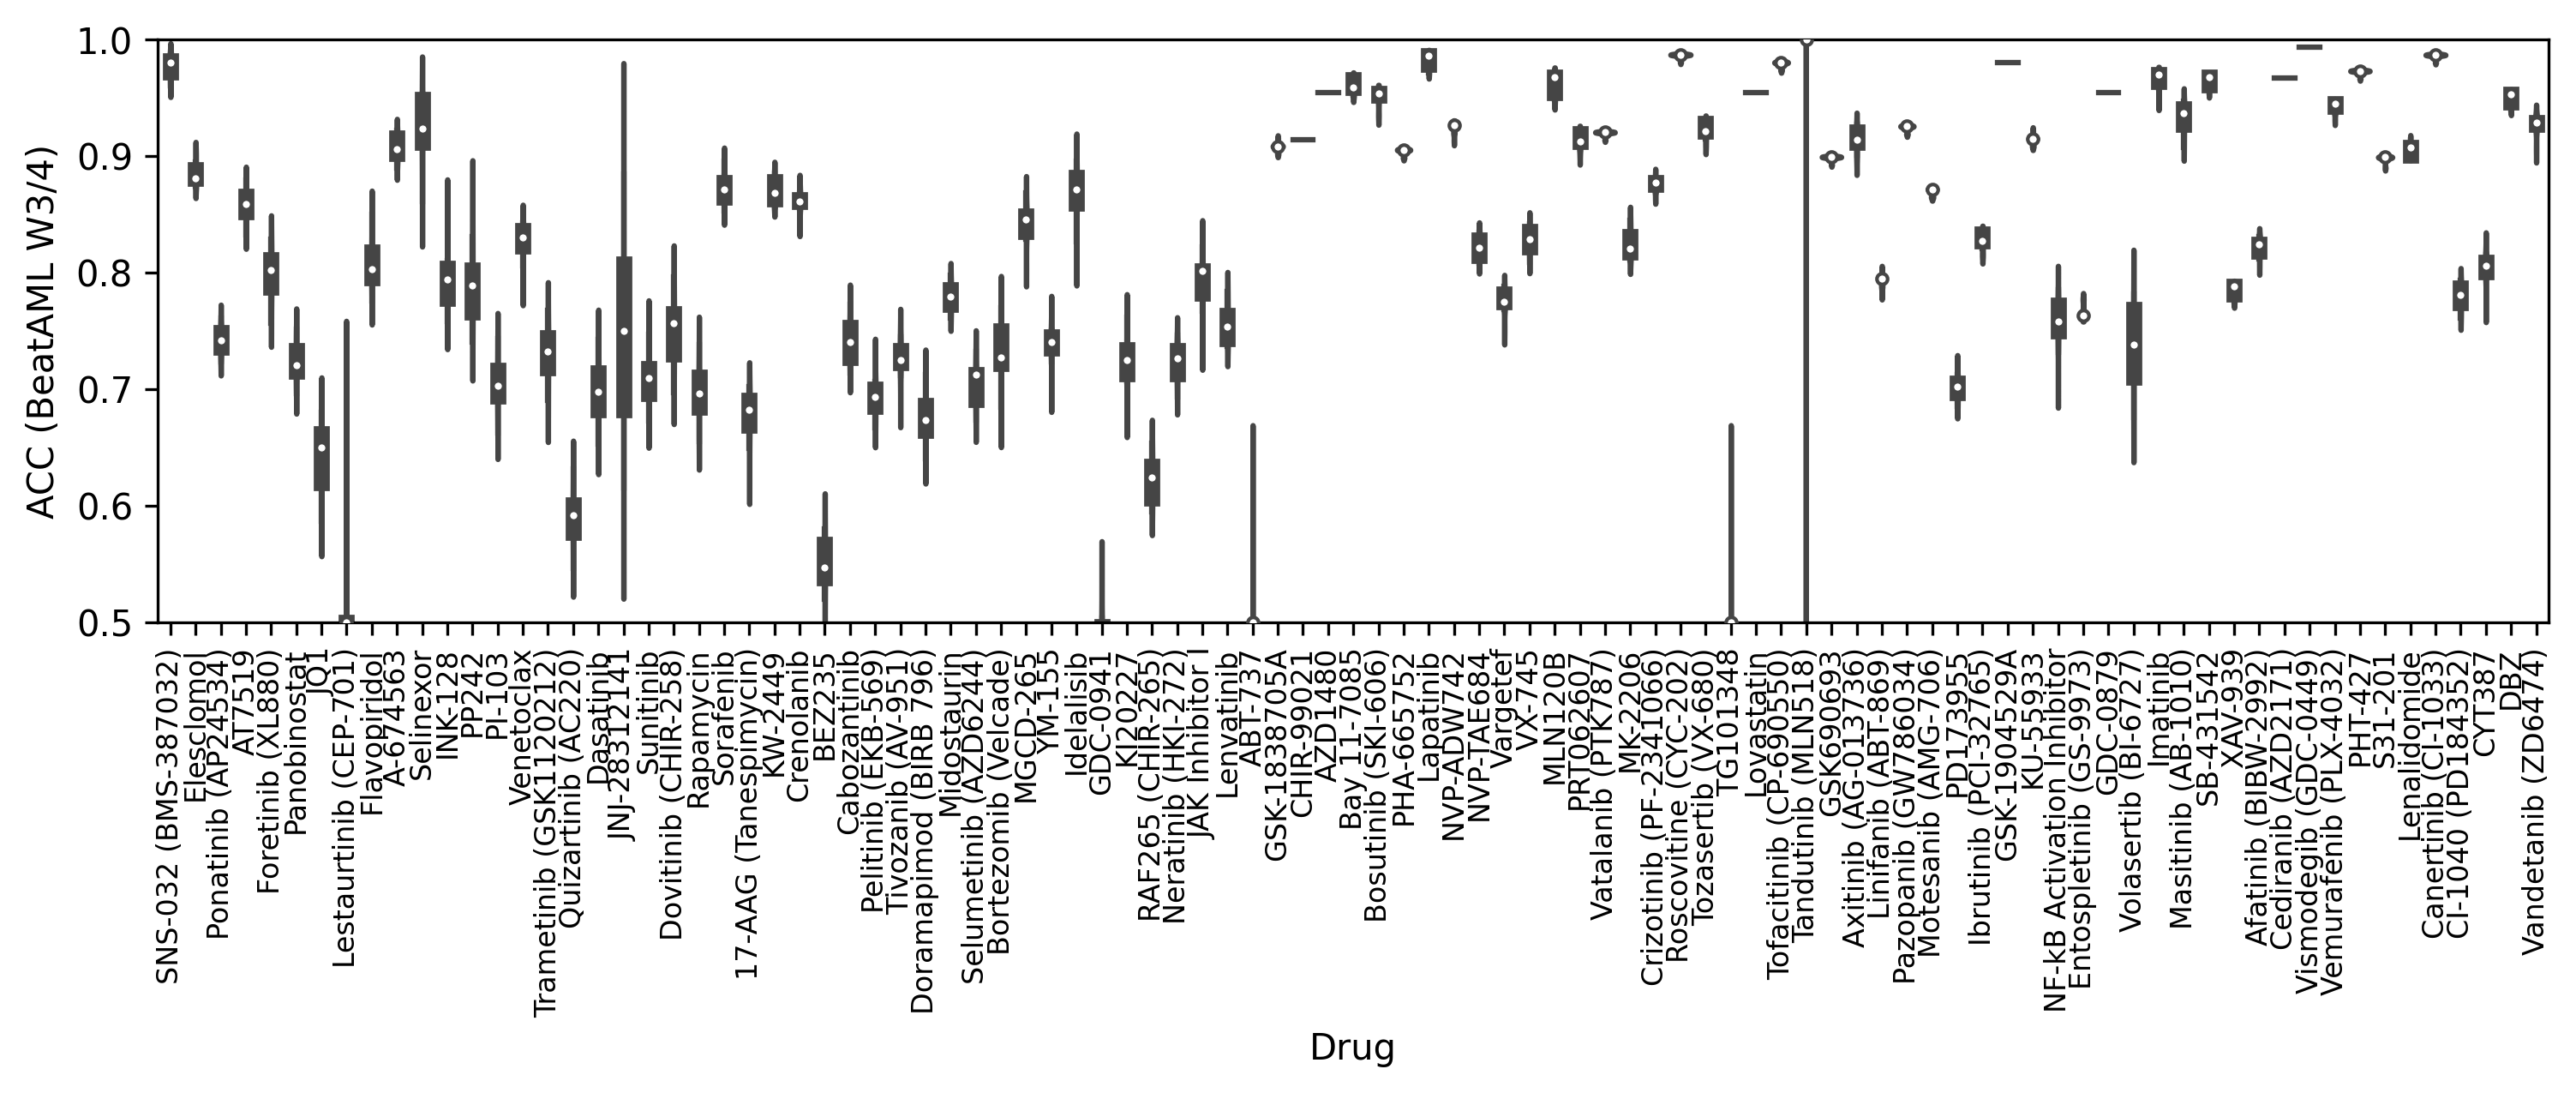

In [106]:
import seaborn as sns
plt.figure(figsize = (12,3),dpi = 300)

sns.violinplot(data = result_final, x="Drug", y="ACC_w3_4", order = order_drugs['Drug'])
plt.ylim(0.5,1)

plt.xticks(np.arange(0,len(Drug_list_sele)), labels = order_drugs['Drug'] , rotation = 90, fontsize =8)

plt.ylabel("ACC (BeatAML W3/4)")


Text(0, 0.5, 'F1 (BeatAML W1/2)')

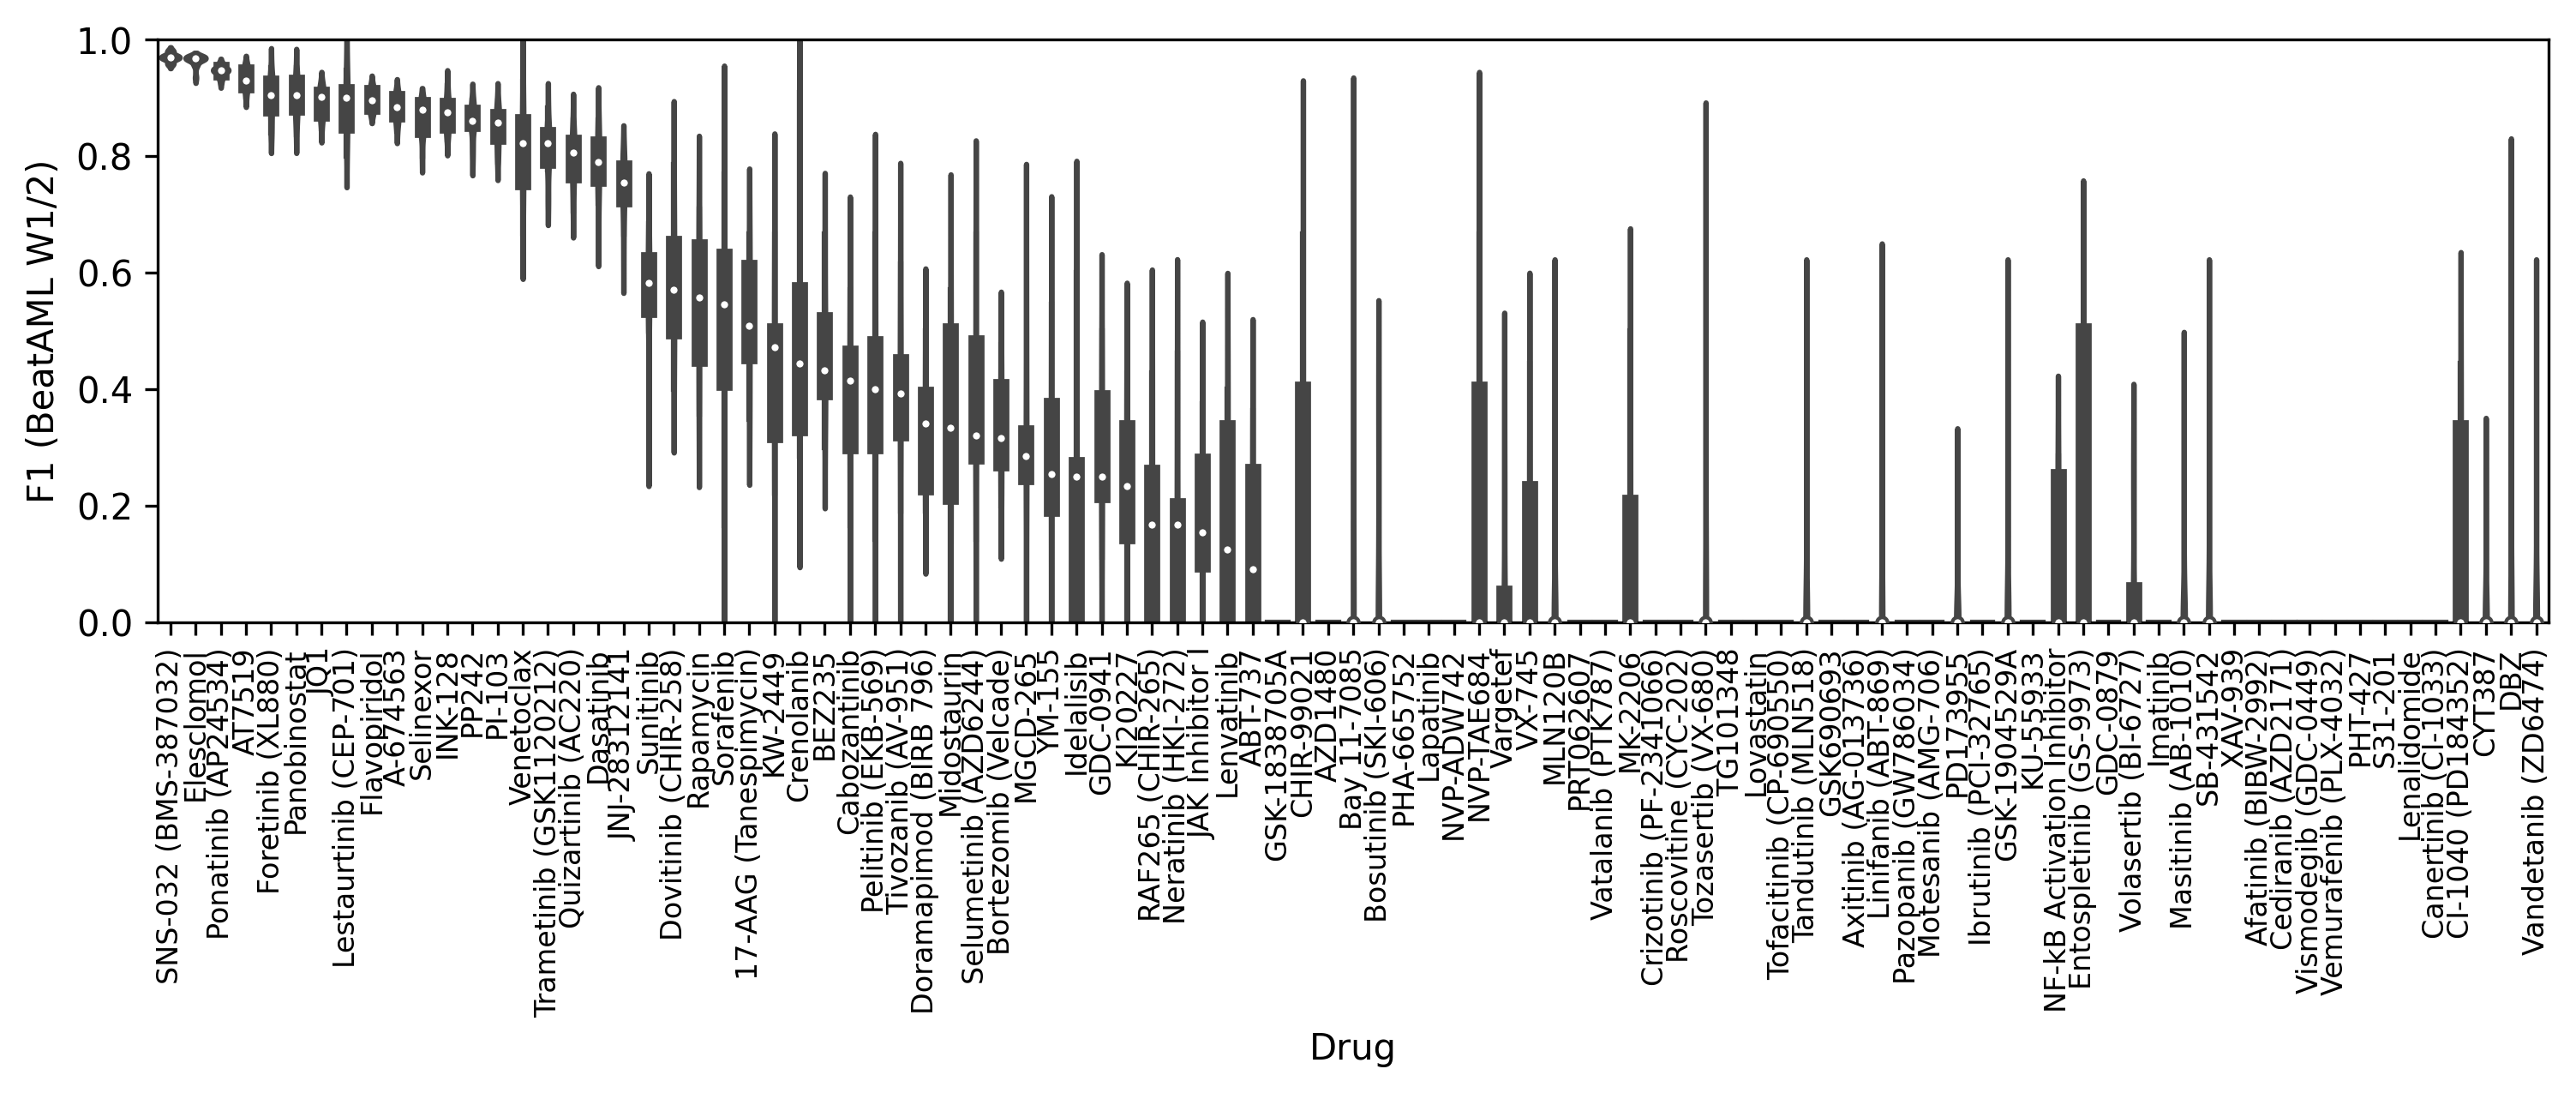

In [107]:
plt.figure(figsize = (12,3),dpi = 300)

sns.violinplot(data = result_final, x="Drug", y="F1_w1_2", order = order_drugs['Drug'])
plt.ylim(0,1)

plt.xticks(np.arange(0,len(Drug_list_sele)), labels = order_drugs['Drug'] , rotation = 90, fontsize =8)

plt.ylabel("F1 (BeatAML W1/2)")


Text(0, 0.5, 'F1 (BeatAML W3/4)')

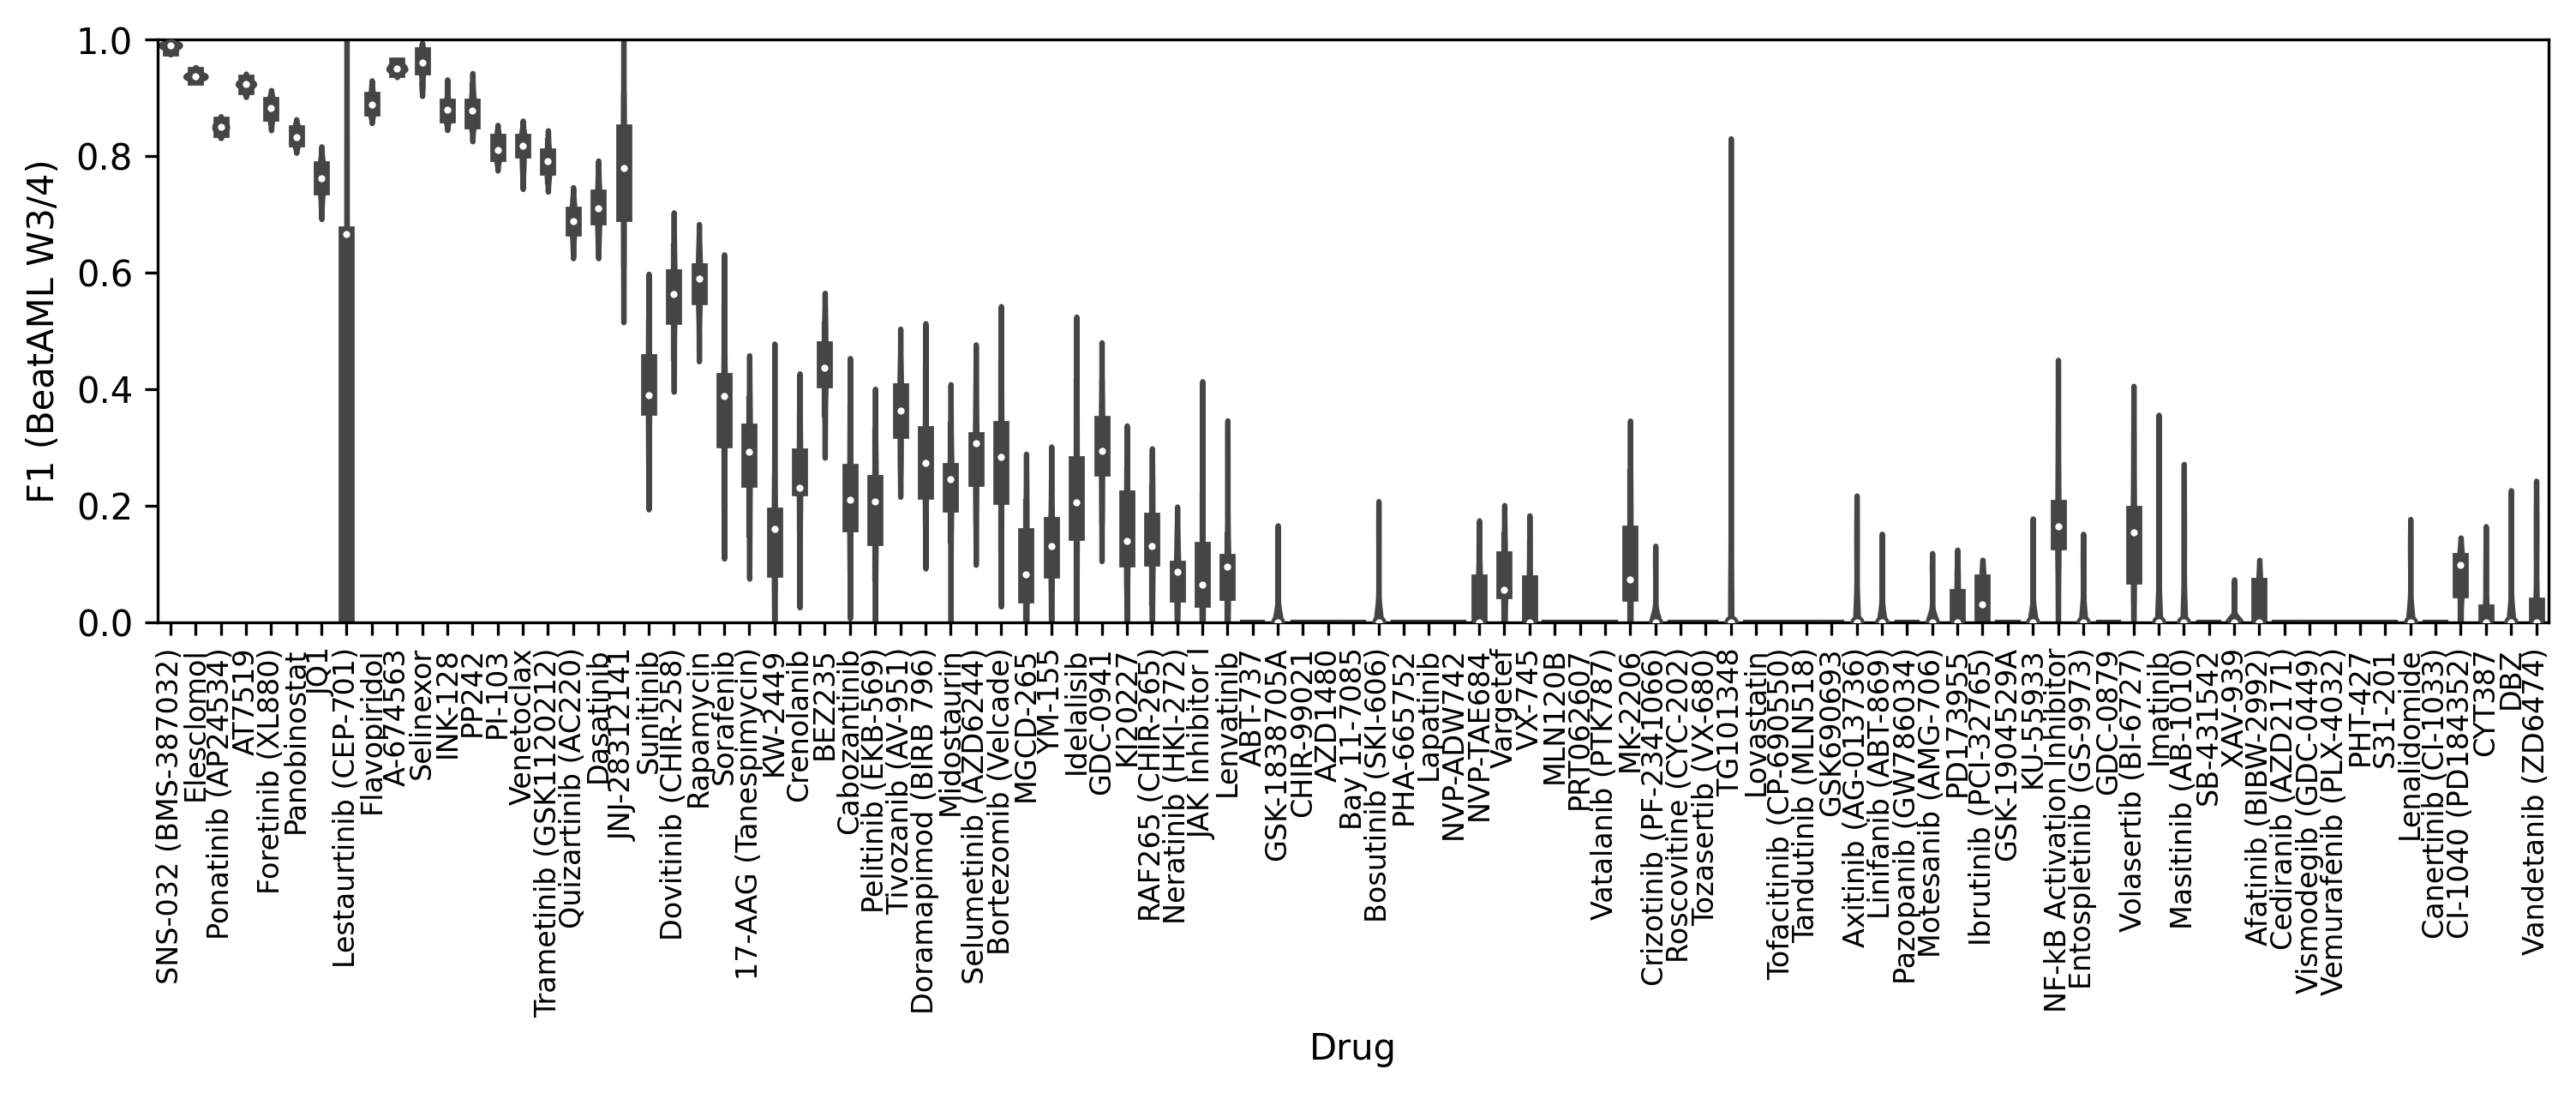

In [108]:
plt.figure(figsize = (12,3),dpi = 300)

sns.violinplot(data = result_final, x="Drug", y="F1_w3_4", order = order_drugs['Drug'])
plt.ylim(0,1)

plt.xticks(np.arange(0,len(Drug_list_sele)), labels = order_drugs['Drug'] , rotation = 90, fontsize =8)

plt.ylabel("F1 (BeatAML W3/4)")


Text(0, 0.5, 'ACC (BeatAML W1/2)')

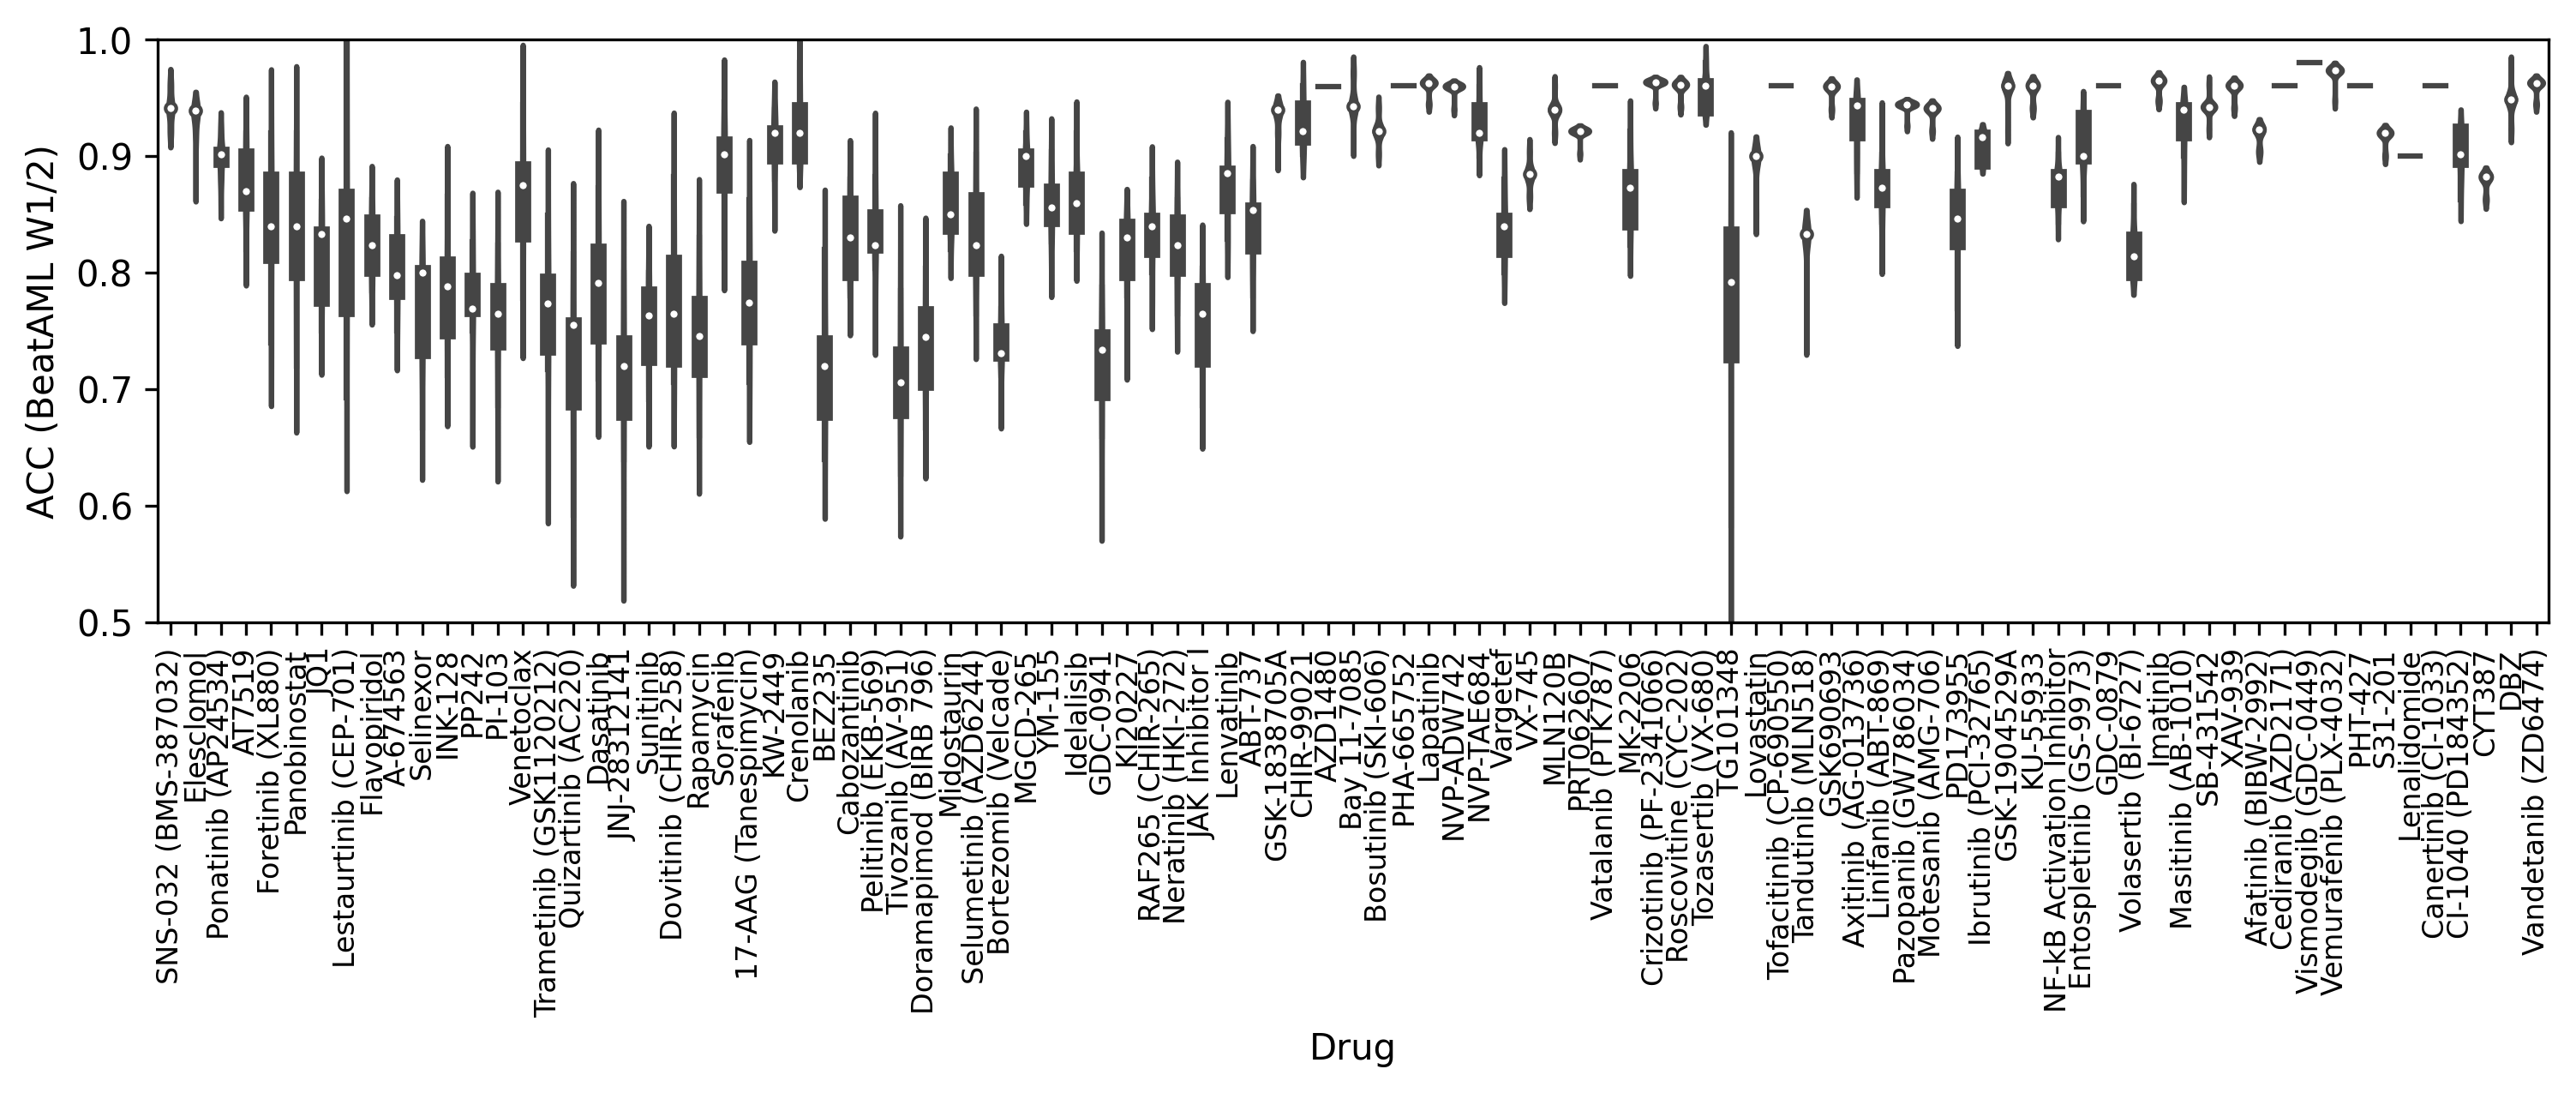

In [109]:
plt.figure(figsize = (12,3),dpi = 300)

sns.violinplot(data = result_final, x="Drug", y="ACC1_2", order = order_drugs['Drug'])
plt.ylim(0.5,1)

plt.xticks(np.arange(0,len(Drug_list_sele)), labels = order_drugs['Drug'] , rotation = 90, fontsize =8)

plt.ylabel("ACC (BeatAML W1/2)")

In [ ]:
# Get feature importance

In [76]:
feature_drug_df = pd.DataFrame()
for drug in order_drugs['Drug']:
    test = result_with_threshod[drug]
    cur = test[sele_threshold[drug]]
    feature_df = pd.DataFrame()
    for random in cur:
        if cur[random]['Accuracy'] > 0.8 :
            feature_df_cur = cur[random]['features']
            feature_df_cur["IMP_"+str(random)]  = feature_df_cur['IMP']
            feature_df_cur.index = feature_df_cur['Feature']
            feature_df = pd.concat([feature_df, feature_df_cur["IMP_"+str(random)] ], axis =1)
    feature_df_sum = feature_df.sum(axis = 1)/feature_df.shape[1]
    result = pd.DataFrame({"features":feature_df_sum.index, 
                           "IMP":feature_df_sum.values, 
                           "Drug":[drug]*len(feature_df_sum.index)})
    
    feature_drug_df = pd.concat([feature_drug_df, result])

In [78]:
feature_drug_df.loc[feature_drug_df['features'] == "WT1"]

features       IMP                     Drug
310      WT1  0.000075               Elesclomol
355      WT1  0.000249        Foretinib (XL880)
27       WT1  0.001140                      JQ1
351      WT1  0.000417             Flavopiridol
122      WT1  0.000449               Venetoclax
173      WT1  0.004398  Trametinib (GSK1120212)
275      WT1  0.001529                Dasatinib
51       WT1  0.002061     Dovitinib (CHIR-258)
319      WT1  0.000061                Sorafenib
11       WT1  0.013471                   BEZ235
0        WT1  0.005583      Pelitinib (EKB-569)
5        WT1  0.007807   Doramapimod (BIRB 796)
249      WT1  0.000240              Midostaurin
341      WT1  0.000967    Selumetinib (AZD6244)
313      WT1  0.000126                   YM-155
3        WT1  0.015332        RAF265 (CHIR-265)
350      WT1  0.000281      Neratinib (HKI-272)
171      WT1  0.000204               Lenvatinib
137      WT1  0.003696                  ABT-737
134      WT1  0.000150               CHIR-99021
114      WT1  0.001723              Bay 11-7085
83       WT1  0.003337                Lapatinib
175      WT1  0.000982                 Vargetef
294      WT1  0.000248                   VX-745
116      WT1  0.000208                  MK-2206
149      WT1  0.001051               Lovastatin
69       WT1  0.009460      Linifanib (ABT-869)
61       WT1  0.007773                 PD173955
157      WT1  0.000267    Ibrutinib (PCI-32765)
9        WT1  0.007250     Volasertib (BI-6727)
32       WT1  0.001266             Lenalidomide
164      WT1  0.001592     Canertinib (CI-1033)
131      WT1  0.000495       CI-1040 (PD184352)
279      WT1  0.000251      Vandetanib (ZD6474)

In [81]:
feature_drug_df.to_csv("IMP_Feature_matrix_acc_gt0.8.csv")

In [79]:
feature_drug_df_sig = feature_drug_df.loc[feature_drug_df['IMP'] > 0.005]

In [80]:
feature_drug_df_sig.to_csv("IMP_Feature_matrix_acc_gt0.8_IMP_gt0.005.csv")

In [82]:
feature_drug_df_sig.sort_values(by = ['Drug'])
feature_drug_df_sig.loc[feature_drug_df_sig['Drug'] == "Venetoclax"]

features       IMP        Drug
0            FGD4-GPS2  0.054110  Venetoclax
1           C1QA-RPS10  0.031528  Venetoclax
2            CD14-GPS1  0.028950  Venetoclax
3         LILRB2-PSMD2  0.034999  Venetoclax
4           FGD4-ZNF91  0.049167  Venetoclax
6           IGF2R-GPS1  0.014166  Venetoclax
7           MTSS1-FNTA  0.012535  Venetoclax
8         C1QA-MIR4519  0.051570  Venetoclax
9            BCL2-MLH1  0.013571  Venetoclax
10           CD14-FNTA  0.077889  Venetoclax
11    SMC5-AS1-MIR4648  0.015630  Venetoclax
12          ACOT9-NFYB  0.008755  Venetoclax
13    VENTX-MIR181A2HG  0.012587  Venetoclax
14          C1QA-PSMC1  0.009061  Venetoclax
15           CD14-ARAF  0.008510  Venetoclax
16         LILRB2-FNTA  0.005958  Venetoclax
17         CASC10-GPS2  0.007591  Venetoclax
18         MTSS1-CEBPA  0.011422  Venetoclax
19        LILRA3-PSMC1  0.009624  Venetoclax
23        ECHDC3-RPS10  0.015051  Venetoclax
24          PAM-ZNF680  0.013237  Venetoclax
25        SPICE1-RPS10  0.010685  Venetoclax
27      LILRA3-MIR3609  0.006017  Venetoclax
29           BCL2-ARAF  0.006976  Venetoclax
30          CLIP4-GPS2  0.007192  Venetoclax
31        LILRB2-PSMC1  0.006351  Venetoclax
32       CASC10-POU6F1  0.009533  Venetoclax
35          NIPBL-ARAF  0.006547  Venetoclax
39        MYO7A-MIR27A  0.008364  Venetoclax
40   LINC00471-MIR5690  0.007136  Venetoclax
42    RP1-257A7.4-GPS2  0.006109  Venetoclax
44          ACOT9-FNTA  0.008570  Venetoclax
45   LINC00471-MIR4648  0.013662  Venetoclax
46           NPC2-ARAF  0.016151  Venetoclax
47           NPC2-CTCF  0.025262  Venetoclax
49            PAM-FNTA  0.007389  Venetoclax
53          FGD4-RPS10  0.018018  Venetoclax
54         MTSS1-NR1I2  0.005021  Venetoclax
55          GDF11-MLH1  0.008908  Venetoclax
56     ADPRHL1-MIR4772  0.008725  Venetoclax
57           C1QA-MLH1  0.006505  Venetoclax
63          BCL2-NFKB2  0.013991  Venetoclax
70           BCL2-GPS1  0.010983  Venetoclax
72          NPC2-SF3B2  0.012547  Venetoclax
74         MTSS1-ZNF91  0.007121  Venetoclax
115         BCL2-FOXO1  0.005671  Venetoclax
131        LILRB2-ARAF  0.014665  Venetoclax
194         CD14-ZNF91  0.024681  Venetoclax

In [83]:
feature_drug_df_sig
drug_family = ["Bosutinib (SKI-606)", "Dasatinib","Imatinib","Nilotinib","PD173955","Ponatinib (AP24534)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['ABL']*feature_common.shape[0]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/781259054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['ABL']*feature_common.shape[0]


In [84]:
feature_common.to_csv("ABL_family_common_features.csv")

In [85]:
#CDK4_6 or pan-CDK predictors
feature_drug_df_sig
drug_family = ["AT7519", "Flavopiridol", "Palbociclib", "BMS-35541", "JNJ-776621", "Roscovitine (CYC-202)",  "SNS-032 (BMS-387032)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['pan-CDK']*feature_common.shape[0]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/1873044831.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['pan-CDK']*feature_common.shape[0]


In [86]:
feature_common.to_csv("pan_CDK_family_common_features.csv")

In [87]:
#RAF_MEK_ERK inhibitor
feature_drug_df_sig
drug_family = ["CL-1040 (PD184352)", "GDC-0879", "PD173955", "RAF265 (CHIR-265)", "Regorafenib (BAY 73-4506)", "Selumetinib (AZD6244)", "Trametinib (GSK1120212)", "Vemurafenib (PLX-4032)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['RAF_MEK_ERK']*feature_common.shape[0]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_56547/187090638.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['RAF_MEK_ERK']*feature_common.shape[0]


In [88]:
#feature_common
feature_common.to_csv("RAF_MEK_ERK_family_common_features.csv")

In [115]:
feature_drug_df_sig.loc[feature_drug_df_sig['features'] == 'ABCB1-ZNF91']

features       IMP                  Drug
142  ABCB1-ZNF91  0.006821  SNS-032 (BMS-387032)
69   ABCB1-ZNF91  0.008510                AT7519
19   ABCB1-ZNF91  0.012038                YM-155

In [626]:
for feature in set(feature_drug_df_sig['features']):
    if feature_drug_df_sig.loc[feature_drug_df_sig['features'] == feature].shape[0]>2:
        print(feature)

TRAK2-ARAF
PCBP3-MIR5581
CD300E-GPS1
DNMT3A
BCOR
CD300E-GNB1
AC002456.2-MIR378I
PRSS21-RPS10
RP4-610C12.3-MIR1282
IGHV1-3-MIR5010
NPM1
RNU5A-1-PSMC1
ACP5-MIR3153
DPEP3-MIR4442
PVRL2-ARAF
CYSLTR2-IRF8
SH3BP4-MIR3192
F13A1-HNRNPK
LRRC3DN-MIR4639
CTD-2006K23.1-MIR503HG
TMEM106B-MIER3
BLMH-MLH1
CYSLTR2-FNTA
PPIEL-GPS2
LBX2-AS1-MIR25
NOV-GPS1
DCTN5-TOX4
FZD6-GPS2
F13A1-GNB1
PVRL2-FOXP1
AC013474.4-MIR4482-1
PAM-ZNF680
CTD-2619J13.9-MIR4292
C10orf128-ZNF91
AMDHD2-PSMC1
CDCP1-MIRLET7D
FAM129B-GPS2
IGSF10-GPS1
ADAM28-FNTA
PAM-MIR17HG
SPP1-GPS2
PRSS21-GPS2
S100A9-SF3B2
APOL4-PSMC1
C15orf39-MTA2
P2RY14-MIR5192
LGALS2-FNTA
RP11-355O1.7-MIR371B
RP11-700J17.2-ZNF91
NFXL1-FNTA
BCOR-KLF9
AC016700.3-GPS2
IDH1
PTK2B-ARAF
CD93-MIR181A1HG
P2RY14-MIR221
LGALS2-GPS2
CYSLTR2-CTCF
DYSF-MIR181A2HG
PAM-ZNF91
FAM219A-FNTA
DHTKD1-GPS1
ATP9A-ZNF91
RAMP1-GPS2
PVRL2-MIR4477A
DYSF-GPS2
RENBP-FNTA
ADAM28-MLH1
AC079325.6-MIR25
S100A9-PSMD2
LBX2-AS1-MIR4292
C10orf128-MIR4519
IDH2
HNMT-MIR221
RNA18S5-FNTA
S100A9-ARAF
FZD

In [532]:
# Visulize the effect of predictors and drug response

# Not used!

0.36


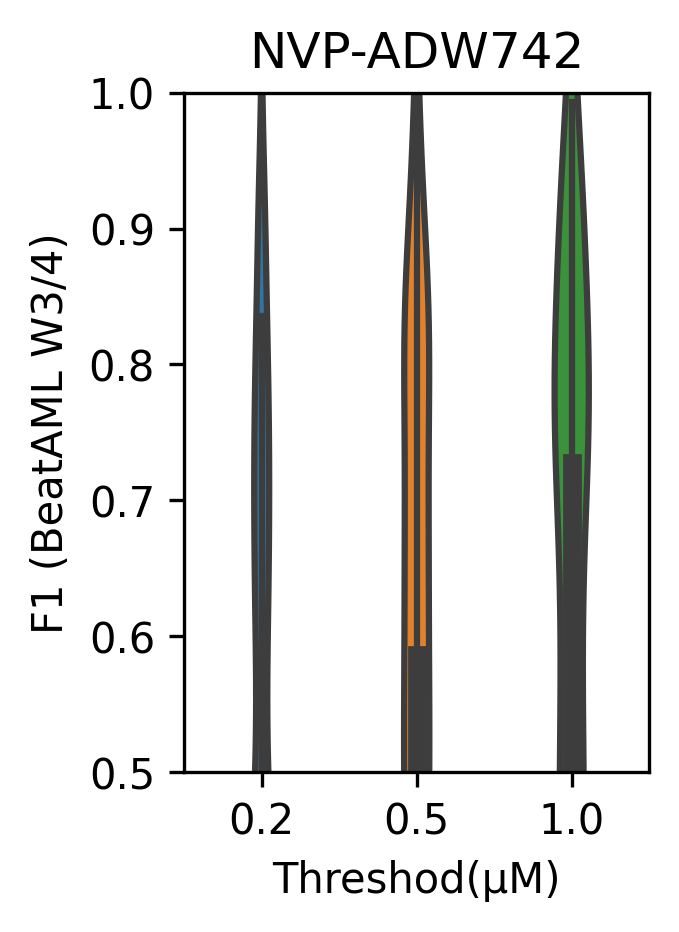

In [90]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
r = pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_w3":F1_independent_test_list})
sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_w3":F1_independent_test_list}),
               x="Threshod(μM)", y="F1_w3"
              )
plt.ylim(0.5,1)
plt.ylabel("F1 (BeatAML W3/4)")
plt.title(Drug.split("(")[0])
print(np.median(r.loc[r['Threshod(μM)'] == 1]['F1_w3']))

In [117]:
# Plot top important features 
feature_IMP =pd.DataFrame()
Threshold = 1
for random_state in result_with_threshod[Threshold]:
    features = result_with_threshod[Threshold][random_state]['features']['Feature'].values
    IMP = result_with_threshod[Threshold][random_state]['features']['IMP'].values
    cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
    cur_df.index = features
    feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
    
IMP_sum = feature_IMP.transpose().sum()
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(100)



In [118]:
 x_feature.sort_values(by = ["IMP"], ascending = False).to_csv("Trametinib_features.csv")

([<matplotlib.axis.XTick at 0x13dffd0f0>,
 [Text(0, 0, 'ATXN7L3-CTCF'),
  Text(1, 0, 'CTD-2006K23.1-MIR3679'),
  Text(2, 0, 'MT-TS1-PSMC1'),
  Text(3, 0, 'OSBPL1A-GPS2'),
  Text(4, 0, 'TNS1-ZBTB18'),
  Text(5, 0, 'NPM1P12-MIR1282'),
  Text(6, 0, 'RP11-267J23.4-MIR4426'),
  Text(7, 0, 'REPS2-GPS2'),
  Text(8, 0, 'OSBPL1A-RORA'),
  Text(9, 0, 'MED13L-SF3B2'),
  Text(10, 0, 'MT-TS1-ZNF91'),
  Text(11, 0, 'RP13-228J13.8-MIR146A'),
  Text(12, 0, 'MLLT10-GABPA'),
  Text(13, 0, 'MT-TS1-GPS2'),
  Text(14, 0, 'OSBPL1A-ZNF91'),
  Text(15, 0, 'TNS1-ZFHX3'),
  Text(16, 0, 'NPAS1-MYCL'),
  Text(17, 0, 'YME1L1-ARAF'),
  Text(18, 0, 'RALGAPA1-ZNF721'),
  Text(19, 0, 'HMGN2P41-RPS10'),
  Text(20, 0, 'RP11-267J23.4-GPS1'),
  Text(21, 0, 'NPM1'),
  Text(22, 0, 'RP11-255C15.4-MIR4639'),
  Text(23, 0, 'YME1L1-PSMD2'),
  Text(24, 0, 'RP11-267J23.4-MLH1'),
  Text(25, 0, 'REPS2-ZNF91'),
  Text(26, 0, 'MT-TS1-FNTA'),
  Text(27, 0, 'CTD-2061E19.1-MIR371B'),
  Text(28, 0, 'RPL39P38-MIR421'),
  Text(29, 0, 'IMPA

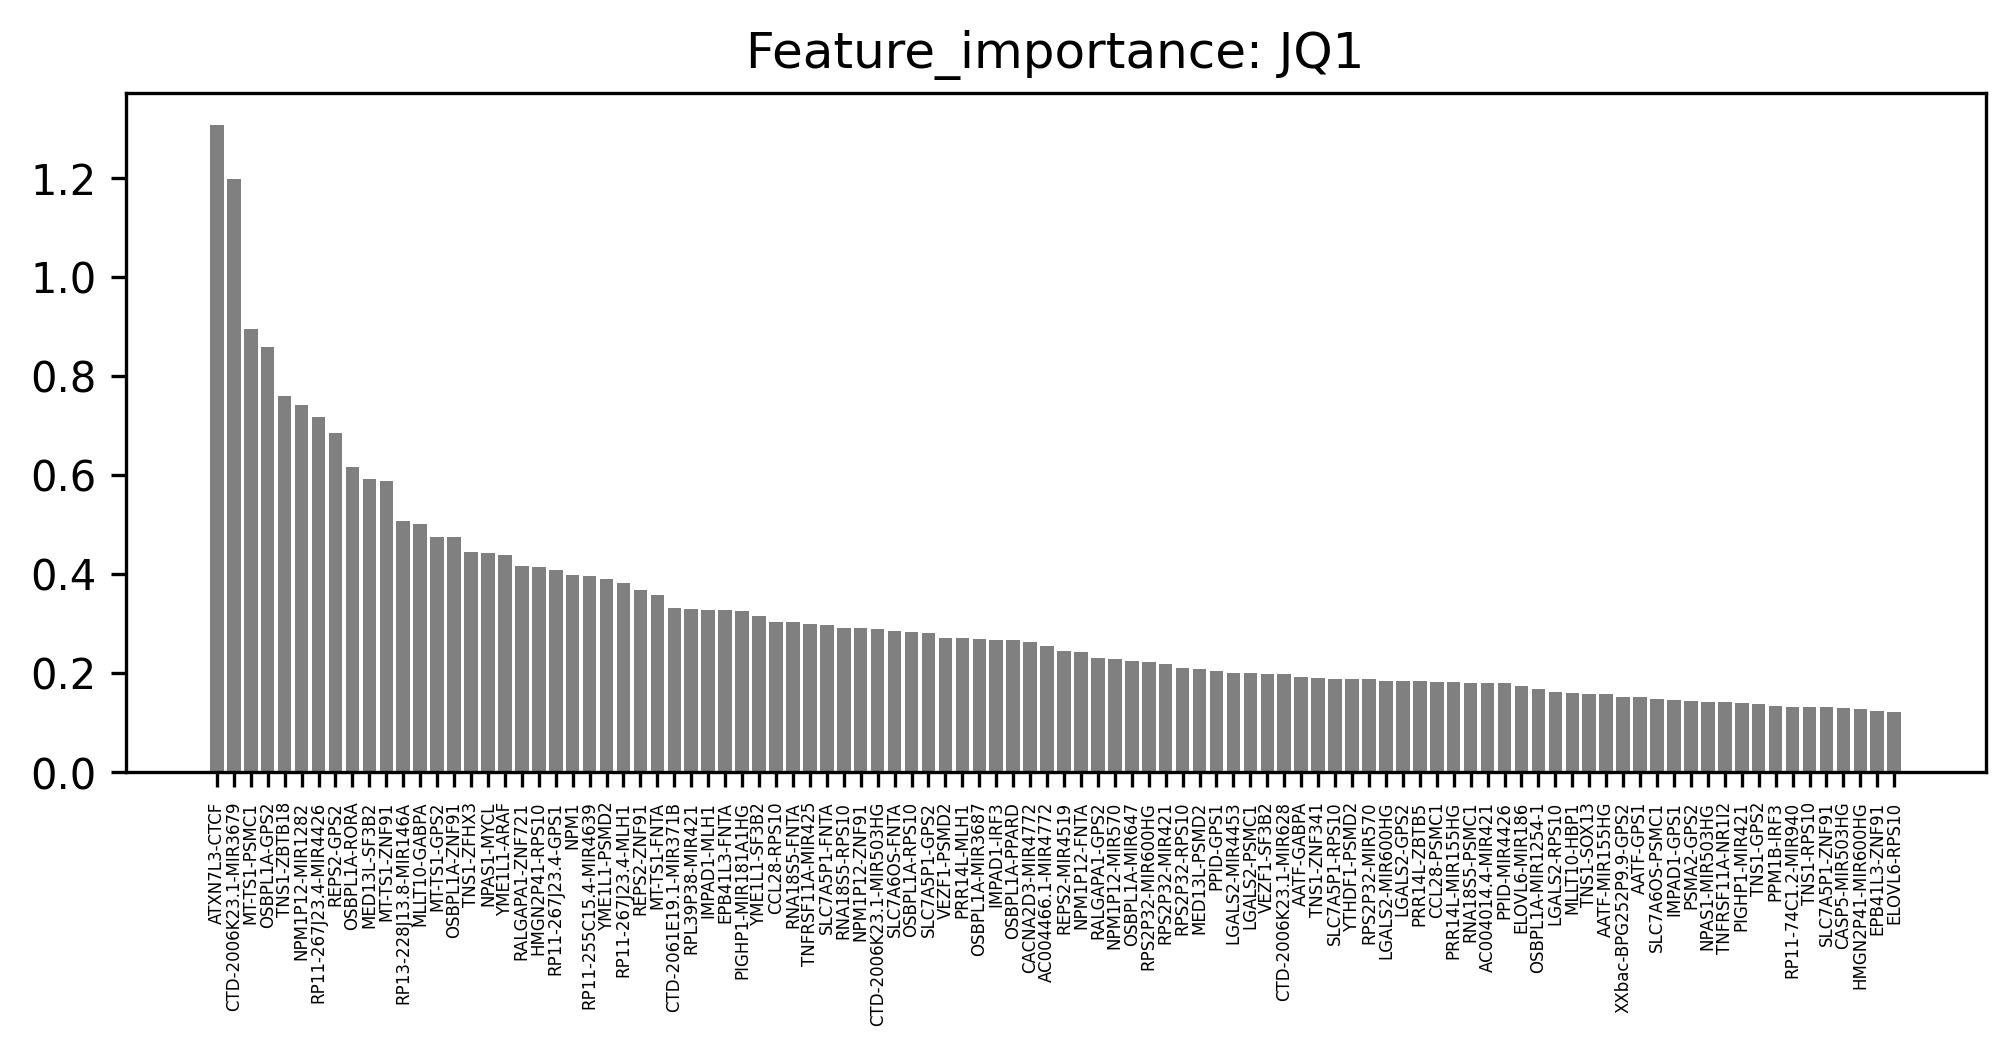

In [119]:
plt.figure(figsize = (8,3),dpi = 300)
plt.title("Feature_importance: " + Drug.split("(")[0])
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")
plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),x_feature_sorted['Feature'] , rotation = 90, fontsize =4)


0.8055555555555556


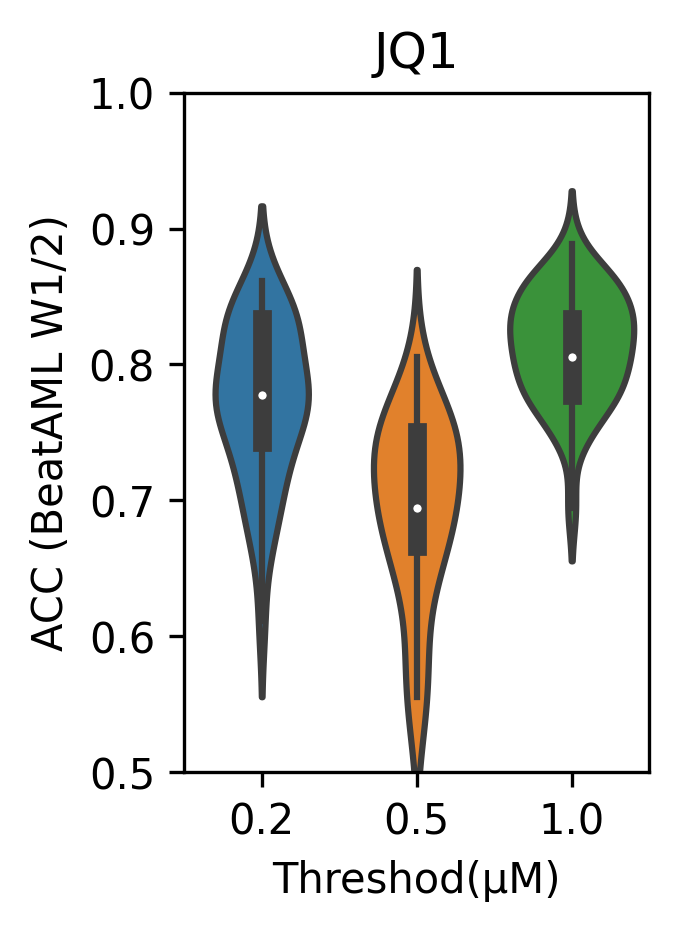

In [120]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
acc_df=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC":ACC_list})
sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC":ACC_list}), x="Threshod(μM)", y="ACC")
plt.ylim(0.5,1)
plt.ylabel("ACC (BeatAML W1/2)")
plt.title(Drug.split("(")[0])
print(np.median(acc_df.loc[acc_df['Threshod(μM)'] == 1]['ACC']))

0.8870673952641166


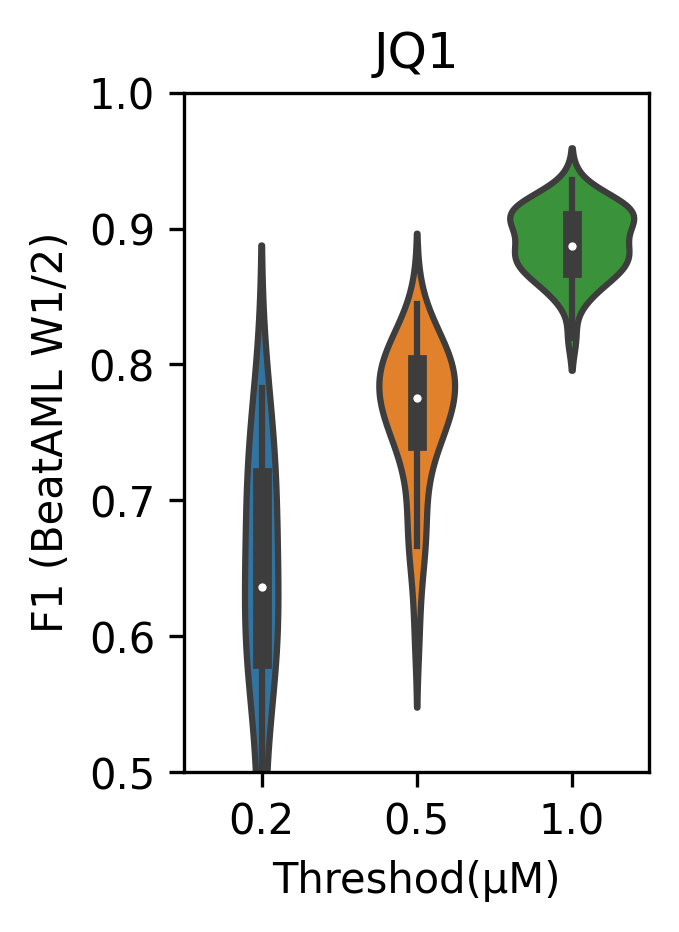

In [121]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
f1_df = pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_score":F1_list})
sns.violinplot(data=f1_df, x="Threshod(μM)", y="F1_score")
#plt.title("Validation Set")
plt.ylim(0.5,1)
plt.ylabel("F1 (BeatAML W1/2)")
plt.title(Drug.split("(")[0])

print(np.median(f1_df.loc[acc_df['Threshod(μM)'] == 1]['F1_score']))

In [122]:
print(np.median(f1_df.loc[f1_df['Threshod(μM)'] == 1]['F1_score']))
print(np.median(acc_df.loc[acc_df['Threshod(μM)'] == 1]['ACC']))


0.8870673952641166
0.8055555555555556
